# Test 

In [187]:
import pandas as pd

df_test = pd.read_parquet("data/test.parquet")

In [254]:
# Compter le nombre de sessions par utilisateur
sessions_par_user = df_test.groupby('userId')['sessionId'].nunique().reset_index()
sessions_par_user.columns = ['userId', 'nombre_sessions']

# Trier par nombre de sessions décroissant et prendre les 5 premiers
top_5_users = sessions_par_user.sort_values('nombre_sessions', ascending=False).head(5)

print(top_5_users)

       userId  nombre_sessions
739   1261737           134438
307   1116029              112
2848  1979129               99
1899  1663631               97
2009  1703411               96


In [256]:
# 1. Compter le nombre de logs par session
logs_par_session = df_test.groupby('sessionId').size().reset_index(name='nombre_logs')

# 2. Les 5 sessions avec le plus de logs
top_5_sessions = logs_par_session.sort_values('nombre_logs', ascending=False).head(5)
print("Top 5 sessions avec le plus de logs :")
print(top_5_sessions)

# 3. Nombre moyen de logs par session
moyenne_logs = logs_par_session['nombre_logs'].mean()
print(f"\nNombre moyen de logs par session : {moyenne_logs:.2f}")

# Statistiques supplémentaires utiles
print(f"Nombre total de sessions : {len(logs_par_session)}")
print(f"Médiane de logs par session : {logs_par_session['nombre_logs'].median()}")
print(f"Écart-type : {logs_par_session['nombre_logs'].std():.2f}")

Top 5 sessions avec le plus de logs :
        sessionId  nombre_logs
97687      128347         1371
108363     143782         1315
135942     185100         1221
53426       64879         1102
128331     173319         1083

Nombre moyen de logs par session : 30.12
Nombre total de sessions : 145863
Médiane de logs par session : 5.0
Écart-type : 70.93


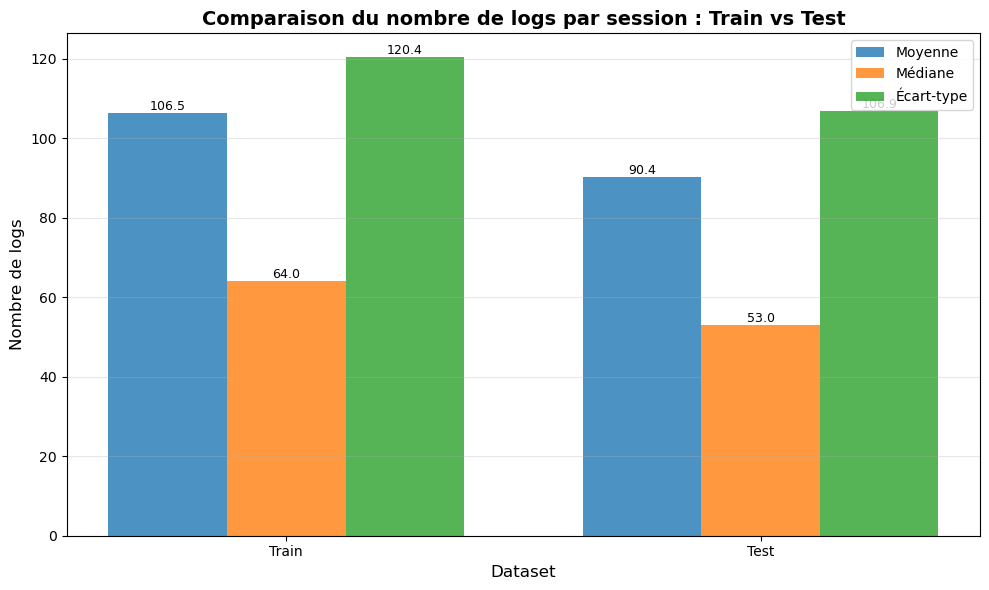

=== STATISTIQUES TRAIN ===
Moyenne: 106.45
Médiane: 64.00
Écart-type: 120.38

=== STATISTIQUES TEST ===
Moyenne: 90.36
Médiane: 53.00
Écart-type: 106.87


In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Charger les données
# df_train = pd.read_csv('train.csv')
# df_test = pd.read_csv('test.csv')

# Calculer les statistiques pour train
logs_par_session_train = df_train.groupby('sessionId').size()
stats_train = {
    'moyenne': logs_par_session_train.mean(),
    'mediane': logs_par_session_train.median(),
    'ecart_type': logs_par_session_train.std()
}

# Calculer les statistiques pour test
logs_par_session_test = data_clean.groupby('sessionId').size()
stats_test = {
    'moyenne': logs_par_session_test.mean(),
    'mediane': logs_par_session_test.median(),
    'ecart_type': logs_par_session_test.std()
}

# Créer le plot
fig, ax = plt.subplots(figsize=(10, 6))

datasets = ['Train', 'Test']
x = np.arange(len(datasets))
width = 0.25

# Barres pour chaque métrique
bars1 = ax.bar(x - width, [stats_train['moyenne'], stats_test['moyenne']], 
               width, label='Moyenne', alpha=0.8)
bars2 = ax.bar(x, [stats_train['mediane'], stats_test['mediane']], 
               width, label='Médiane', alpha=0.8)
bars3 = ax.bar(x + width, [stats_train['ecart_type'], stats_test['ecart_type']], 
               width, label='Écart-type', alpha=0.8)

# Personnalisation
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Nombre de logs', fontsize=12)
ax.set_title('Comparaison du nombre de logs par session : Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Afficher aussi les stats en texte
print("=== STATISTIQUES TRAIN ===")
print(f"Moyenne: {stats_train['moyenne']:.2f}")
print(f"Médiane: {stats_train['mediane']:.2f}")
print(f"Écart-type: {stats_train['ecart_type']:.2f}")

print("\n=== STATISTIQUES TEST ===")
print(f"Moyenne: {stats_test['moyenne']:.2f}")
print(f"Médiane: {stats_test['mediane']:.2f}")
print(f"Écart-type: {stats_test['ecart_type']:.2f}")

### Function

In [190]:
def create_test_featuresV4(df_test, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (V4 - CLEANED VERSION).
    Removed redundant/low-importance features from V3.
    """
    
    print("Starting feature engineering V4 (cleaned version)...")
    
    # Copy and optimize data types
    df = df_test.copy()
    
    print("Optimizing data types...")
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start']
    
    # Pre-compute window boundaries
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    session_info['days_since_registration'] = (
        (session_info['session_start'] - session_info['registration']).dt.total_seconds() / 86400
    ).clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            user_item_in_session = user_logs['itemInSession'].values if 'itemInSession' in user_logs.columns else None
            
            for session_row in user_sessions.itertuples(index=False):
                session_id = session_row.sessionId
                session_start = session_row.session_start
                registration_date = session_row.registration
                window_start = session_row.window_start
                window_end = session_row.window_end
                days_since_registration = session_row.days_since_registration
                
                # Exclude current session
                exclude_current_session = user_session_ids != session_id
                
                # Window mask
                window_mask = (
                    (user_times >= window_start) & 
                    (user_times < window_end) & 
                    exclude_current_session
                )
                
                window_pages = user_pages[window_mask]
                window_times = user_times[window_mask]
                window_session_ids = user_session_ids[window_mask]
                if user_item_in_session is not None:
                    window_item_in_session = user_item_in_session[window_mask]
                else:
                    window_item_in_session = None
                
                # Calculate inactivity
                previous_mask = (user_times < window_end) & exclude_current_session
                previous_times = user_times[previous_mask]
                
                if len(previous_times) > 0:
                    last_action_time = pd.Timestamp(previous_times[-1])
                    hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
                else:
                    hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
                
                # Page counting
                if len(window_pages) > 0:
                    unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                    page_count_dict = dict(zip(unique_pages, page_counts))
                else:
                    page_count_dict = {}
                
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                num_sessions = len(np.unique(window_session_ids)) if total_actions > 0 else 0
                
                # Calculate key metrics
                count_next_song = get_count('NextSong')
                count_thumbs_up = get_count('Thumbs Up')
                
                # Skip rate calculation
                skip_count = 0
                if window_item_in_session is not None and len(window_item_in_session) > 1:
                    nextsong_mask = window_pages == 'NextSong'
                    nextsong_sessions = window_session_ids[nextsong_mask]
                    nextsong_items = window_item_in_session[nextsong_mask]
                    
                    for sess_id in np.unique(nextsong_sessions):
                        sess_items = nextsong_items[nextsong_sessions == sess_id]
                        if len(sess_items) > 1:
                            diffs = np.diff(sess_items)
                            skip_count += np.sum(diffs > 1)
                
                # Previous week for variation
                previous_week_start = window_start - pd.Timedelta(days=7)
                previous_week_end = window_start
                
                previous_week_mask = (
                    (user_times >= previous_week_start) & 
                    (user_times < previous_week_end) & 
                    exclude_current_session
                )
                
                previous_week_pages = user_pages[previous_week_mask]
                previous_week_actions = len(previous_week_pages)
                
                # Activity variation
                if previous_week_actions > 0:
                    activity_variation = ((total_actions - previous_week_actions) / previous_week_actions) * 100
                else:
                    activity_variation = 0 if total_actions == 0 else 100
                
                # Music consumption variation
                if len(previous_week_pages) > 0:
                    prev_unique, prev_counts = np.unique(previous_week_pages, return_counts=True)
                    prev_dict = dict(zip(prev_unique, prev_counts))
                    previous_week_songs = prev_dict.get('NextSong', 0)
                else:
                    previous_week_songs = 0
                
                if previous_week_songs > 0:
                    music_consumption_variation = ((count_next_song - previous_week_songs) / previous_week_songs) * 100
                else:
                    music_consumption_variation = 0 if count_next_song == 0 else 100
                
                # Features
                features = {
                    'sessionId': session_id,
                    'userId': str(user_id),
                    'session_start': session_start,
                    'registration': registration_date,
                    
                    # Temporal
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Actions
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_friend': get_count('Add Friend'),
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global
                    'total_actions': total_actions,
                    'num_sessions': num_sessions,
                    
                    # Key ratios
                    'skip_rate': skip_count / count_next_song if count_next_song > 0 else 0,
                    'like_ratio': count_thumbs_up / count_next_song if count_next_song > 0 else 0,
                    
                    # Variations
                    'activity_variation_pct': activity_variation,
                    'music_consumption_variation_pct': music_consumption_variation,
                    'previous_week_actions': previous_week_actions,
                    
                    # Flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                    'has_negative_engagement': int(get_count('Thumbs Down') > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")

    return df_features

In [191]:
# Vérifier le type
df_test = df_train_test.copy()
print(f"Type of userId in df_test: {df_test['userId'].dtype}")

# Essaie avec string
num_logs = (df_test['userId'] == '1261737').sum()
print(f"User '1261737' (string) appears {num_logs} times")

# Ou convertir
num_logs = (df_test['userId'].astype(str) == '1261737').sum()
print(f"User 1261737 appears {num_logs} times")

# Pour être sûr, regarde les valeurs
print(f"\nFirst 5 userId values: {df_test['userId'].head().tolist()}")

Type of userId in df_test: object
User '1261737' (string) appears 653681 times
User 1261737 appears 653681 times

First 5 userId values: ['1465194', '1465194', '1465194', '1465194', '1465194']


In [192]:
data_clean = df_test[df_test['userId'] != '1261737']


In [193]:
df_test_features = create_test_featuresV4(data_clean, lookback_days=60, batch_size=1000)

Starting feature engineering V4 (cleaned version)...
Optimizing data types...
Dataset size: 3,739,498 logs
Users: 2,903, Sessions: 41,384
Extracting session information...
Processing 41,384 sessions in batches of 1000 users...
  Processed batch 3/3 (41,384 sessions so far)
Creating final dataframe...

✓ Final dataset: 41,384 rows, 23 features
Label distribution:


### EDA

In [194]:
df_test_features.describe()

,session_start,registration,hours_since_last_action,days_since_registration,count_help,count_about,count_error,count_thumbs_down,count_add_friend,count_settings,...,total_actions,num_sessions,skip_rate,like_ratio,activity_variation_pct,music_consumption_variation_pct,previous_week_actions,has_downgrade_action,has_upgrade_action,has_negative_engagement
count,41384,41384,41384.000000,41384.000000,41384.000000,41384.000000,41384.000000,41384.000000,41384.000000,41384.000000,...,41384.000000,41384.000000,41384.000000,41384.000000,41384.000000,41384.000000,41384.0,41384.000000,41384.000000,41384.000000
mean,2018-10-25 11:33:35.625821952,2018-08-27 16:29:29.773729024,119.267631,58.794512,5.523077,2.052484,1.058404,9.859922,16.114247,6.240576,...,1080.661826,12.844336,0.168703,0.050878,93.415330,93.209936,0.0,0.598613,0.673666,0.818650
min,2018-10-01 00:00:06,2017-12-25 02:45:40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,2018-10-12 14:05:13,2018-08-14 18:23:24,12.025347,33.659193,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,172.000000,3.000000,0.145952,0.041542,100.000000,100.000000,0.0,0.000000,0.000000,1.000000
50%,2018-10-25 06:24:56.500000,2018-09-06 23:20:39,34.582083,51.313189,3.000000,1.000000,0.000000,5.000000,9.000000,3.000000,...,587.000000,9.000000,0.168518,0.050000,100.000000,100.000000,0.0,1.000000,1.000000,1.000000
75%,2018-11-07 02:54:59.249999872,2018-09-21 00:48:32,92.523750,74.917367,8.000000,3.000000,2.000000,14.000000,23.000000,9.000000,...,1527.000000,18.000000,0.201721,0.059013,100.000000,100.000000,0.0,1.000000,1.000000,1.000000
max,2018-11-19 23:58:38,2018-11-19 16:36:59,6727.014722,327.292338,57.000000,22.000000,14.000000,105.000000,161.000000,60.000000,...,9842.000000,111.000000,0.800000,1.000000,100.000000,100.000000,0.0,1.000000,1.000000,1.000000
std,NaN,NaN,320.201964,37.466081,7.207610,2.886264,1.611837,12.630778,20.134824,7.806771,...,1313.332935,13.598205,0.066142,0.030475,24.801694,25.157836,0.0,0.490185,0.468877,0.385313


### Predict

In [195]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

df_features = df_consistant

feature_cols = [col for col in df_features.columns 
                if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

X = df_features[feature_cols].fillna(0)
y = df_features['will_churn_10days']

print(f"Features: {len(feature_cols)}")
print(f"Dataset size: {len(X)}")
print(f"Label distribution:\n{y.value_counts(normalize=True)}")

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest with better parameters for imbalanced data
model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=15,               # Limit depth to avoid overfitting
    min_samples_split=10,       # Minimum samples to split a node
    min_samples_leaf=5,         # Minimum samples in a leaf
    class_weight='balanced',    # CRITICAL: Handle class imbalance
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn

# Evaluation with appropriate metrics
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

print(f"\nAccuracy: {model.score(X_test, y_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Feature importance
print("\nTop 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

Features: 24
Dataset size: 119755
Label distribution:
will_churn_10days
0    0.892272
1    0.107728
Name: proportion, dtype: float64

MODEL EVALUATION

Accuracy: 0.8674
F1-Score: 0.4443
ROC-AUC: 0.7911

Confusion Matrix:
[[19504  1867]
 [ 1310  1270]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.91      0.92     21371
       Churn       0.40      0.49      0.44      2580

    accuracy                           0.87     23951
   macro avg       0.67      0.70      0.68     23951
weighted avg       0.88      0.87      0.87     23951


Top 10 Most Important Features:
                feature  importance
days_since_registration    0.105895
hours_since_last_action    0.099243
          total_actions    0.087923
             like_ratio    0.086968
              skip_rate    0.073177
      count_thumbs_down    0.066636
       count_add_friend    0.062170
      count_roll_advert    0.055790
           num_sessions    0.055761
    

In [196]:
model_rf_SMOTE

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

In [197]:
def predict_churn(model, df_test_features, best_threshold=0.5):
    """
    Predict churn on test data using trained model with custom threshold.
    
    Parameters:
    -----------
    model : trained classifier (RandomForest, XGBoost, etc.)
        Model from training function
    df_test_features : pd.DataFrame
        Output from create_features_test()
    best_threshold : float, default=0.5
        Optimal threshold for classification (from threshold optimization)
    
    Returns:
    --------
    pd.DataFrame with predictions and probabilities
    """
    # Prepare features (same as training)
    feature_cols = [col for col in df_test_features.columns 
                    if col not in ['userId', 'session_start', 'registration']]
    X_test = df_test_features[feature_cols].fillna(0)
    
    print(f"Predicting on {len(X_test):,} sessions...")
    print(f"Using threshold: {best_threshold:.3f}")
    
    # Get probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Apply custom threshold
    y_pred = (y_pred_proba >= best_threshold).astype(int)
    
    # Create results dataframe
    results = df_test_features[['userId']].copy()
    results['churn_probability'] = y_pred_proba
    results['predicted_churn'] = y_pred
    
    # Statistics
    print(f"\n{'='*50}")
    print(f"PREDICTIONS (threshold = {best_threshold:.3f})")
    print(f"{'='*50}")
    print(f"  Will churn (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")
    print(f"  No churn (0):   {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")
    print(f"\nProbability Statistics:")
    print(f"  Average: {y_pred_proba.mean():.3f}")
    print(f"  Median:  {np.median(y_pred_proba):.3f}")
    print(f"  Min:     {y_pred_proba.min():.3f}")
    print(f"  Max:     {y_pred_proba.max():.3f}")
    print(f"\nRisk Segments:")
    print(f"{'='*50}\n")
    
    return results

In [198]:
# Meilleur threshold basé sur les résultats du test: 0.55
best_threshold = 0.55

In [199]:
# 3. Predict
submission = predict_churn(model_rf_SMOTE, df_test_features, best_threshold=best_threshold)

Predicting on 41,384 sessions...
Using threshold: 0.550

PREDICTIONS (threshold = 0.550)
  Will churn (1): 6,762 (16.3%)
  No churn (0):   34,622 (83.7%)

Probability Statistics:
  Average: 0.352
  Median:  0.333
  Min:     0.000
  Max:     0.947

Risk Segments:



In [200]:
# Créer une ligne pour user 1261737
new_row = pd.DataFrame({
    'userId': ['1261737'],
    'predicted_churn': [0]
})

# Ajouter à ton submission
submission_complete = pd.concat([submission, new_row], ignore_index=True)

print(f"Submission before: {len(submission)} rows")
print(f"Submission after: {len(submission_complete)} rows")

# Vérifier
print(f"\nUser 1261737 in submission: {'1261737' in submission_complete['userId'].values}")

Submission before: 41384 rows
Submission after: 41385 rows

User 1261737 in submission: True


In [201]:
# Renommer les colonnes pour Kaggle
submission_final = submission_complete.rename(columns={
    'userId': 'id',
    'predicted_churn': 'target'
})

# Vérifier
print("Submission structure:")
print(submission_final.head())
print(f"\nColumns: {submission_final.columns.tolist()}")
print(f"Shape: {submission_final.shape}")

# Vérifier pas de null
print(f"\nNull values: {submission_final.isnull().sum()}")

print("\n✓ Submission ready with columns: id, target")

Submission structure:
        id  churn_probability  target
0  1000963           0.268171       0
1  1000963           0.365331       0
2  1000963           0.264960       0
3  1000963           0.463146       0
4  1000963           0.590993       1

Columns: ['id', 'churn_probability', 'target']
Shape: (41385, 3)

Null values: id                   0
churn_probability    1
target               0
dtype: int64

✓ Submission ready with columns: id, target


In [202]:
# Grouper par userId : 1 si au moins un 1, sinon 0
submission_final = submission_final.groupby('id').agg({
    'target': 'max'  # max = 1 si au moins un 1, sinon 0
}).reset_index()

print(f"After deduplication: {len(submission_final)} unique users")
print(f"\nTarget distribution:")
print(submission_final['target'].value_counts())

# Vérifier plus de duplicates
print(f"\nDuplicates: {submission_final['id'].duplicated().sum()}")


After deduplication: 2886 unique users

Target distribution:
target
0    1782
1    1104
Name: count, dtype: int64

Duplicates: 0


In [203]:
# 1. Identifier les userId manquants
expected_users = df_test['userId'].unique()
submitted_users = submission_final['id'].unique()

print(f"Expected users: {len(expected_users)}")
print(f"Submitted users: {len(submitted_users)}")

# Trouver les manquants
missing_users = set(expected_users) - set(submitted_users)
print(f"\nMissing users: {len(missing_users)}")
print(f"Missing user IDs: {list(missing_users)[:10]}")  # Afficher les 10 premiers

# 2. Créer des lignes pour les utilisateurs manquants (avec target=0)
missing_rows = pd.DataFrame({
    'id': list(missing_users),
    'target': 0
})

# 3. Ajouter à la submission
submission_complete = pd.concat([submission_final, missing_rows], ignore_index=True)

print(f"\nBefore adding missing: {len(submission_final)} rows")
print(f"After adding missing: {len(submission_complete)} rows")

# 4. Vérifier qu'on a bien 2904
assert len(submission_complete) == 2904, f"Expected 2904, got {len(submission_complete)}"

# 5. Trier par id (optionnel mais propre)
submission_complete = submission_complete.sort_values('id').reset_index(drop=True)

# 6. Sauvegarder
submission_complete.to_csv('submission.csv', index=False)
print("\n✓ Complete submission with all 2904 users saved!")

Expected users: 2904
Submitted users: 2886

Missing users: 18
Missing user IDs: ['1146605', '1474758', '1940610', '1678265', '1075974', '1311784', '1222773', '1681149', '1973354', '1805463']

Before adding missing: 2886 rows
After adding missing: 2904 rows

✓ Complete submission with all 2904 users saved!


# Train

The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [331]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [332]:
df_train.describe()

,status,ts,sessionId,itemInSession,length,time,registration
count,1.749964e+07,1.749964e+07,1.749964e+07,1.749964e+07,1.429143e+07,17499636,17499636
mean,2.091387e+02,1.540428e+12,8.480294e+04,1.055937e+02,2.487135e+02,2018-10-25 00:47:01.161927,2018-08-25 04:40:21.543066
min,2.000000e+02,1.538352e+12,1.000000e+00,0.000000e+00,5.220000e-01,2018-10-01 00:00:01,2017-10-14 22:05:25
25%,2.000000e+02,1.539340e+12,2.515900e+04,2.600000e+01,1.998885e+02,2018-10-12 10:33:57.750000,2018-08-10 21:14:59
50%,2.000000e+02,1.540397e+12,7.903800e+04,6.600000e+01,2.340828e+02,2018-10-24 15:58:54,2018-09-05 18:35:50
75%,2.000000e+02,1.541500e+12,1.383680e+05,1.440000e+02,2.768714e+02,2018-11-06 10:25:35,2018-09-20 17:24:57
max,4.040000e+02,1.542672e+12,2.070030e+05,1.426000e+03,3.024666e+03,2018-11-20 00:00:00,2018-11-19 23:34:34
std,3.023050e+01,1.233485e+09,6.141427e+04,1.168854e+02,9.722845e+01,NaN,NaN


### Creation of target feature

In [306]:
df_train[(df_train['page'] == 'Cancellation Confirmation') & (df_train['level'] == 'free')]

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
7411981,200,M,Konner,free,Thomas,1528783,1540299148000,Cancelled,Cancellation Confirmation,111103,"Roanoke, VA",25,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",GET,NaN,None,None,2018-10-23 12:52:28,2018-06-27 00:13:31
11493069,200,F,Madison,free,Wright,1230041,1541332925000,Cancelled,Cancellation Confirmation,150420,"Seattle-Tacoma-Bellevue, WA",26,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",GET,NaN,None,None,2018-11-04 12:02:05,2018-09-22 01:07:49
59364,200,M,Brayden,free,Martin,1277353,1538376254000,Cancelled,Cancellation Confirmation,25539,"Spokane-Spokane Valley, WA",9,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,GET,NaN,None,None,2018-10-01 06:44:14,2018-09-01 08:09:05
653149,200,F,Katarina,free,Martin,1916157,1538531240000,Cancelled,Cancellation Confirmation,32756,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",146,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",GET,NaN,None,None,2018-10-03 01:47:20,2018-08-14 14:56:28
2705174,200,M,Braylon,free,Willis,1121796,1539096280000,Cancelled,Cancellation Confirmation,58307,"Riverside-San Bernardino-Ontario, CA",248,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",GET,NaN,None,None,2018-10-09 14:44:40,2018-09-17 03:27:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23837187,200,F,Harmoni,free,Allison,1172943,1539826948000,Cancelled,Cancellation Confirmation,15001,"Torrington, CT",9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",GET,NaN,None,None,2018-10-18 01:42:28,2018-08-04 20:35:20
23208418,200,F,Erika,free,Flowers,1517349,1538869860000,Cancelled,Cancellation Confirmation,3084,"Jackson, MS",126,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",GET,NaN,None,None,2018-10-06 23:51:00,2018-09-19 09:14:12
23345125,200,F,Holly,free,Green,1396378,1539103077000,Cancelled,Cancellation Confirmation,1039,"Atlanta-Sandy Springs-Roswell, GA",122,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",GET,NaN,None,None,2018-10-09 16:37:57,2018-07-31 23:27:58
23337405,200,M,Ayden,free,Kaufman,1835694,1539096554000,Cancelled,Cancellation Confirmation,1680,"San Francisco-Oakland-Hayward, CA",33,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",GET,NaN,None,None,2018-10-09 14:49:14,2018-08-23 00:07:25


In [333]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [334]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

In [336]:
# create a dataset for free users and paying users

df_train_free = df_train[df_train["level"] == "free"].copy()
df_train_paid = df_train[df_train["level"] == "paid"].copy()

In [337]:
df_train_paid.sample(10)

users_free = df_train_free["userId"]
users_paid = df_train_paid["userId"]

overlap = users_free[users_free.isin(users_paid)]
print(f"Number of overlapping users: {overlap.nunique()}")
print(f"Total number of users {df_train["userId"].nunique()}")


#Lots of users that switch from free to paid 

Number of overlapping users: 9244
Total number of users 18884


## Preliminary EDA

In [338]:
import pandas as pd
import numpy as np

# --- 1. Simulation de votre DataFrame (df_train) ---
# Dans un scénario réel, vous auriez déjà chargé ce DataFrame.
# Ici, nous créons 100 000 lignes pour simuler un grand jeu de données.

print(f"Taille initiale de df_train: {len(df_train)} lignes.")

# --- 2. Échantillonnage aléatoire de 1% (1/100e) ---
# frac=0.01 signifie que nous prenons 1% des lignes.
# random_state=42 assure que l'échantillon sera le même à chaque exécution (reproductibilité).
df_sample = df_train.sample(frac=0.006, random_state=42)

# --- 3. Affichage et vérification ---
print(f"Taille de l'échantillon (0.006%): {len(df_sample)} lignes.")
print("\nAperçu de l'échantillon :")
print(df_sample.head())

# --- 4. Création du fichier CSV ---
output_filename = "df_train_sample.csv"
# index=False pour ne pas inclure l'index du DataFrame dans le fichier CSV.
df_sample.to_csv(output_filename, index=False)

print(f"\nÉchantillon enregistré dans le fichier : {output_filename}")

Taille initiale de df_train: 14657548 lignes.
Taille de l'échantillon (0.006%): 87945 lignes.

Aperçu de l'échantillon :
         status gender firstName level  lastName   userId             ts  \
4717181     200      M     Mario  paid     Lucas  1590986  1540384853000   
8287201     200      F     Angel  paid    Morris  1833605  1539035076000   
8185883     200      M     Lucas  paid   Beasley  1198970  1541443982000   
7601906     200      M     Lucas  paid  Peterson  1143843  1541263818000   
4998109     200      F   Zaliyah  paid      King  1403205  1539175857000   

              auth      page  sessionId  \
4717181  Logged In  NextSong     111959   
8287201  Logged In  NextSong      56997   
8185883  Logged In  NextSong     152868   
7601906  Logged In  NextSong     150559   
4998109  Logged In  NextSong      63420   

                                             location  itemInSession  \
4717181         New York-Newark-Jersey City, NY-NJ-PA            148   
8287201            

In [339]:
columns = ['status', 'firstName', 'level', 'lastName', 'userId', 'ts',
       'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent',
       'method', 'length', 'song', 'artist', 'time', 'registration',
       'will_churn_10days', 'day_month']

In [340]:
import pandas as pd
import numpy as np

# Identifier les churners et leur date de churn
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churn_dates = churners.groupby('userId')['time'].min().reset_index()
churn_dates.columns = ['userId', 'churn_date']

print(f"Nombre d'utilisateurs qui ont churné : {len(churn_dates)}")
print(f"Taux de churn global : {len(churn_dates) / df_train['userId'].nunique() * 100:.2f}%")
churn_dates['churn_date'] = churn_dates['churn_date'].dt.date
churn_dates

Nombre d'utilisateurs qui ont churné : 4271
Taux de churn global : 22.62%


,userId,churn_date
0,1000025,2018-10-18
1,1000083,2018-10-12
2,1000280,2018-11-13
3,1000353,2018-10-22
4,1000503,2018-10-13
...,...,...
4266,1999022,2018-11-04
4267,1999035,2018-10-01
4268,1999668,2018-10-02
4269,1999847,2018-10-18


In [341]:
# Compter le nombre de sessions par utilisateur
sessions_par_user = df_train.groupby('userId')['sessionId'].nunique().reset_index()
sessions_par_user.columns = ['userId', 'nombre_sessions']

# Trier par nombre de sessions décroissant et prendre les 5 premiers
top_5_users = sessions_par_user.sort_values('nombre_sessions', ascending=False).head(5)

print(top_5_users)

        userId  nombre_sessions
16717  1884384               92
2171   1113757               92
12550  1664232               90
3847   1199183               89
18682  1989666               87


In [342]:
# 1. Compter le nombre de logs par session
logs_par_session = df_train.groupby('sessionId').size().reset_index(name='nombre_logs')

# 2. Les 5 sessions avec le plus de logs
top_5_sessions = logs_par_session.sort_values('nombre_logs', ascending=False).head(5)
print("Top 5 sessions avec le plus de logs :")
print(top_5_sessions)

# 3. Nombre moyen de logs par session
moyenne_logs = logs_par_session['nombre_logs'].mean()
print(f"\nNombre moyen de logs par session : {moyenne_logs:.2f}")

# Statistiques supplémentaires utiles
print(f"Nombre total de sessions : {len(logs_par_session)}")
print(f"Médiane de logs par session : {logs_par_session['nombre_logs'].median()}")
print(f"Écart-type : {logs_par_session['nombre_logs'].std():.2f}")

Top 5 sessions avec le plus de logs :
        sessionId  nombre_logs
43010       47184         1393
73197       84971         1385
76450       89129         1329
97601      116166         1257
105068     125892         1250

Nombre moyen de logs par session : 106.45
Nombre total de sessions : 137694
Médiane de logs par session : 64.0
Écart-type : 120.38


In [343]:
df_train['userId'].nunique()

18884

In [344]:
churners['level'].value_counts()

level
paid    2879
free    1392
Name: count, dtype: int64

/var/folders/42/4qk9d5xn1zb22gk9hbqpxdwh0000gn/T/ipykernel_4754/2962433904.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1, 0].bar(range(1, 50), [dom_counts.get(i, 0) for i in range(1, 50)])
/var/folders/42/4qk9d5xn1zb22gk9hbqpxdwh0000gn/T/ipykernel_4754/2962433904.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend()


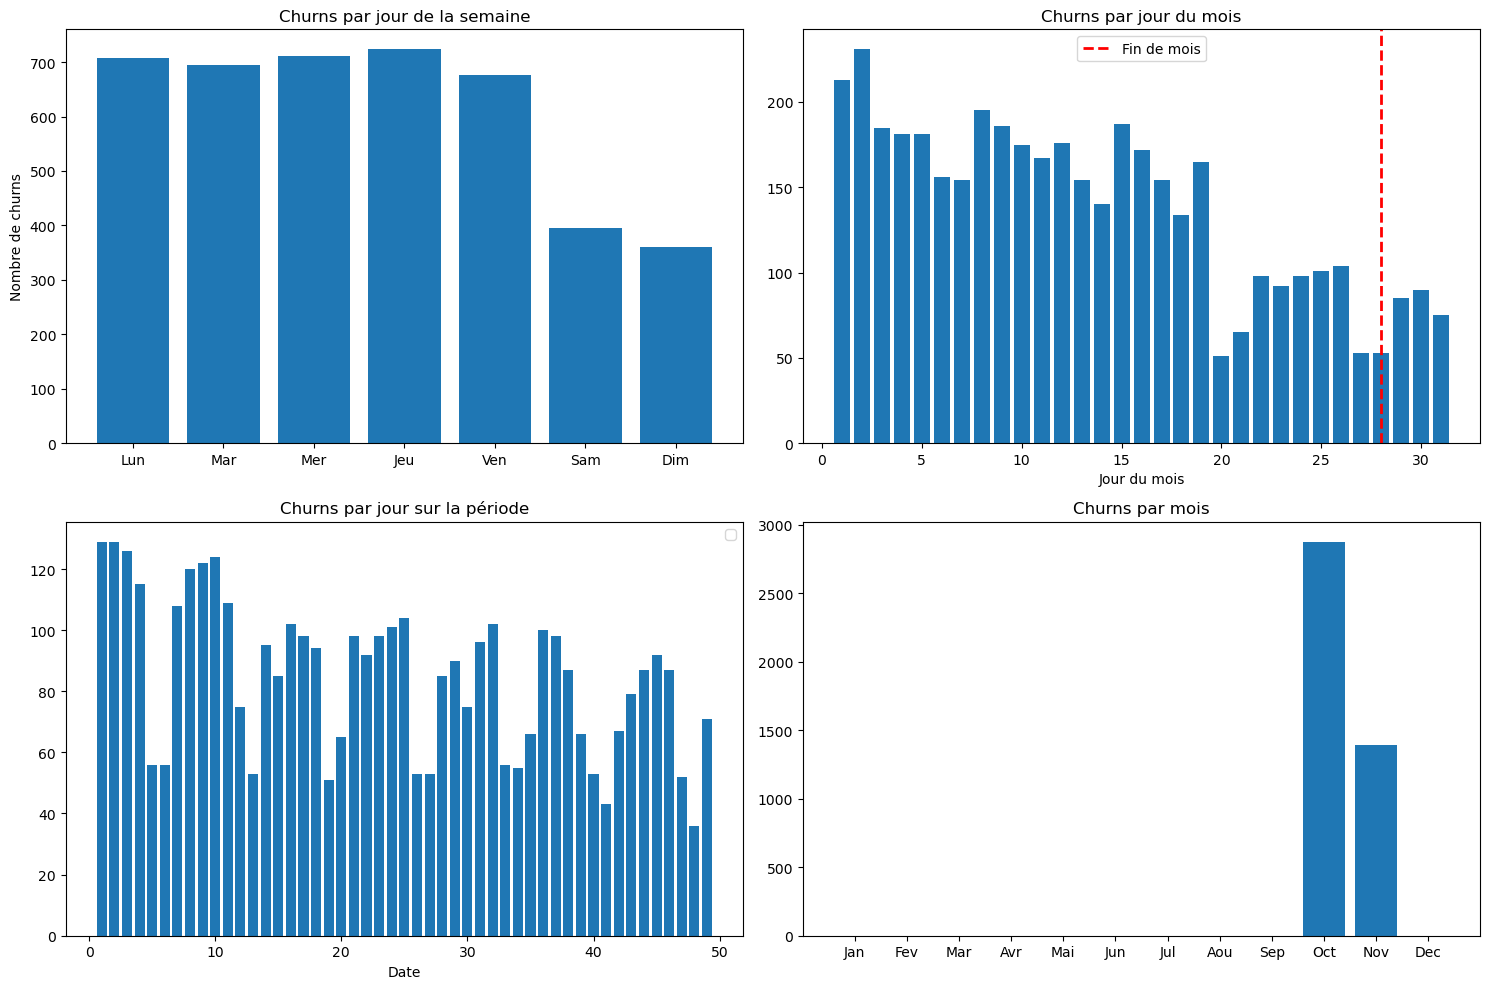

In [345]:
# Quand les gens annulent-ils ?
churn_dates['day_of_week'] = pd.to_datetime(churn_dates['churn_date']).dt.dayofweek
churn_dates['day_of_month'] = pd.to_datetime(churn_dates['churn_date']).dt.day
churn_dates['month'] = pd.to_datetime(churn_dates['churn_date']).dt.month

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Par jour de la semaine
dow_counts = churn_dates['day_of_week'].value_counts().sort_index()
axes[0, 0].bar(range(7), dow_counts.values)
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'])
axes[0, 0].set_title('Churns par jour de la semaine')
axes[0, 0].set_ylabel('Nombre de churns')

# Par jour du mois
dom_counts = churn_dates['day_of_month'].value_counts().sort_index()
axes[0, 1].bar(range(1, 32), [dom_counts.get(i, 0) for i in range(1, 32)])
axes[0, 1].axvline(x=28, color='r', linestyle='--', label='Fin de mois', linewidth=2)
axes[0, 1].set_title('Churns par jour du mois')
axes[0, 1].set_xlabel('Jour du mois')
axes[0, 1].legend()

# Par jour de l'année
dom_counts = churn_dates['churn_date'].value_counts().sort_index()
axes[1, 0].bar(range(1, 50), [dom_counts.get(i, 0) for i in range(1, 50)])
axes[1, 0].set_title('Churns par jour sur la période')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()

# Par mois
month_counts = churn_dates['month'].value_counts().sort_index()
axes[1, 1].bar(range(1, 13), [month_counts.get(i, 0) for i in range(1, 13)])
axes[1, 1].set_title('Churns par mois')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Jun', 
                            'Jul', 'Aou', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

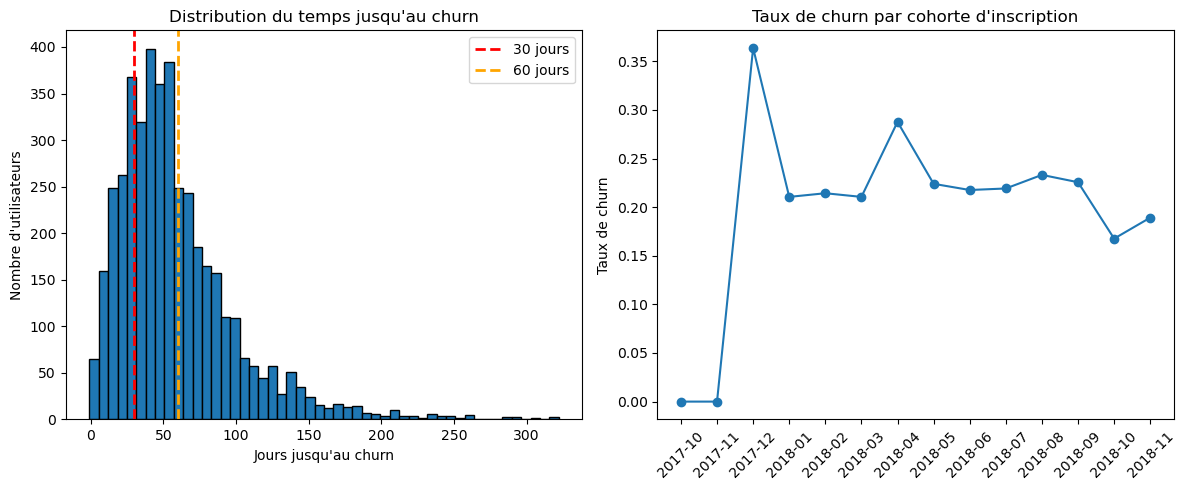


📈 Insights cohortes :
Pic de churn autour de : 50 jours
Médiane temps jusqu'au churn : 50 jours


In [346]:
# Les churns varient-ils selon la période d'inscription ?
all_users = df_train.groupby('userId').agg({
    'registration': 'first',
    'time': ['min', 'max']
}).reset_index()

all_users.columns = ['userId', 'registration', 'first_activity', 'last_activity']
all_users = all_users.merge(churn_dates[['userId', 'churn_date']], 
                             on='userId', how='left')

# Temps jusqu'au churn
all_users['days_to_churn'] = (
    (pd.to_datetime(all_users['churn_date']) - 
     pd.to_datetime(all_users['registration'])).dt.days
)

# Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(all_users[all_users['days_to_churn'].notna()]['days_to_churn'], 
         bins=50, edgecolor='black')
plt.axvline(x=30, color='r', linestyle='--', label='30 jours', linewidth=2)
plt.axvline(x=60, color='orange', linestyle='--', label='60 jours', linewidth=2)
plt.xlabel('Jours jusqu\'au churn')
plt.ylabel('Nombre d\'utilisateurs')
plt.title('Distribution du temps jusqu\'au churn')
plt.legend()

# Taux de churn par cohorte d'inscription
all_users['registration_month'] = pd.to_datetime(all_users['registration']).dt.to_period('M')
churn_by_cohort = all_users.groupby('registration_month').agg({
    'userId': 'count',
    'churn_date': lambda x: x.notna().sum()
}).reset_index()
churn_by_cohort['churn_rate'] = (
    churn_by_cohort['churn_date'] / churn_by_cohort['userId']
)

plt.subplot(1, 2, 2)
plt.plot(churn_by_cohort['registration_month'].astype(str), 
         churn_by_cohort['churn_rate'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Taux de churn')
plt.title('Taux de churn par cohorte d\'inscription')
plt.tight_layout()
plt.show()

print(f"\n📈 Insights cohortes :")
print(f"Pic de churn autour de : {all_users['days_to_churn'].mode().values[0]:.0f} jours")
print(f"Médiane temps jusqu'au churn : {all_users['days_to_churn'].median():.0f} jours")


🔻 Analyse Downgrade → Churn :
Users qui ont downgrade puis churné : 3113
Délai médian downgrade → churn : 12 jours


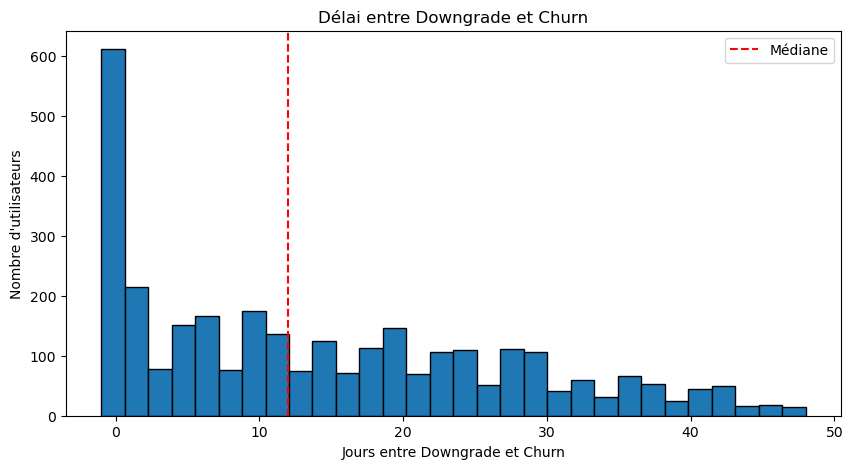

In [347]:
# Les utilisateurs qui downgrade churnent-ils rapidement après ?
downgrades = df_train[df_train['page'] == 'Downgrade'].copy()
downgrade_dates = downgrades.groupby('userId')['time'].min().reset_index()
downgrade_dates.columns = ['userId', 'downgrade_date']

# Merge avec les churners
churn_after_downgrade = churn_dates.merge(downgrade_dates, on='userId', how='inner')
churn_after_downgrade['days_downgrade_to_churn'] = (
    (pd.to_datetime(churn_after_downgrade['churn_date']) - 
     pd.to_datetime(churn_after_downgrade['downgrade_date'])).dt.days
)

print(f"\n🔻 Analyse Downgrade → Churn :")
print(f"Users qui ont downgrade puis churné : {len(churn_after_downgrade)}")
print(f"Délai médian downgrade → churn : {churn_after_downgrade['days_downgrade_to_churn'].median():.0f} jours")

# Distribution
plt.figure(figsize=(10, 5))
plt.hist(churn_after_downgrade['days_downgrade_to_churn'], bins=30, edgecolor='black')
plt.xlabel('Jours entre Downgrade et Churn')
plt.ylabel('Nombre d\'utilisateurs')
plt.title('Délai entre Downgrade et Churn')
plt.axvline(x=churn_after_downgrade['days_downgrade_to_churn'].median(), 
            color='r', linestyle='--', label='Médiane')
plt.legend()
plt.show()

In [348]:
numerical_columns = ['ts', 'itemInSession', 'status', 'length','hour', 'month']
categorical_columns = ['auth', 'page', 'location', 'userAgent',
                       'method', 'song', 'artist']
target_column = ['will_churn_10days']
time_columns = ['time', 'registration']
all_columns = numerical_columns + categorical_columns + target_column + time_columns

## Feature preprocessing

In [349]:
# Sampling the dataset to try the functions:
sample_users = df_train['userId'].drop_duplicates().sample(n=1000, random_state=42)
sample_df_train = df_train[df_train['userId'].isin(sample_users)].copy()

# Selection of columns to simplify the dataset
columns_selection = ['userId', 'time', 'page', 'registration', 'sessionId',
              'itemInSession', 'will_churn_10days']
sample_df_train = sample_df_train[columns_selection]
sample_df_train.sample(10)

,userId,time,page,registration,sessionId,itemInSession,will_churn_10days
660139,1920313,2018-10-25 11:43:46,NextSong,2018-09-19 09:07:58,120558,248,0
11605024,1493710,2018-10-23 12:27:44,NextSong,2018-08-23 04:52:10,104941,178,0
12459123,1142545,2018-11-05 16:17:32,NextSong,2018-09-03 22:51:15,86841,34,0
6173504,1080348,2018-10-19 16:38:07,NextSong,2018-08-25 18:00:37,96820,160,0
9192331,1779156,2018-10-23 18:49:57,NextSong,2018-06-07 08:23:03,113742,96,1
16662691,1846324,2018-11-06 07:15:31,NextSong,2018-09-17 11:48:11,26683,32,0
4296338,1920820,2018-10-17 14:03:13,Home,2018-08-11 20:09:11,76487,0,0
10074234,1226562,2018-11-08 00:53:18,NextSong,2018-09-16 17:59:17,164111,4,0
13502352,1974795,2018-10-04 20:59:24,NextSong,2018-06-20 04:43:18,6339,68,1
13767844,1313985,2018-10-05 03:38:52,Add Friend,2018-06-30 15:05:39,3800,20,1


In [323]:
"""
Script pour créer des features dérivées du userAgent
Applicable sur df_train, df_test, ou tout autre dataset
"""

import pandas as pd
import numpy as np


def parse_user_agent(ua):
    """
    Parse le userAgent pour extraire device, OS et browser
    
    Args:
        ua: string du userAgent
        
    Returns:
        dict avec keys: 'os', 'browser', 'device'
    """
    if pd.isna(ua):
        return {'os': 'Unknown', 'browser': 'Unknown', 'device': 'Unknown'}
    
    ua_str = str(ua)
    
    # Détecter le device
    if 'iPhone' in ua_str:
        device = 'iPhone'
    elif 'iPad' in ua_str:
        device = 'iPad'
    elif 'Android' in ua_str:
        device = 'Android'
    elif 'Windows' in ua_str or 'Macintosh' in ua_str or 'Linux' in ua_str or 'X11' in ua_str:
        device = 'Desktop'
    else:
        device = 'Unknown'
    
    # Détecter l'OS
    if 'Windows NT 10' in ua_str:
        os = 'Windows 10'
    elif 'Windows NT 6.3' in ua_str:
        os = 'Windows 8.1'
    elif 'Windows NT 6.2' in ua_str:
        os = 'Windows 8'
    elif 'Windows NT 6.1' in ua_str:
        os = 'Windows 7'
    elif 'Windows NT 6.0' in ua_str:
        os = 'Windows Vista'
    elif 'Windows NT 5' in ua_str:
        os = 'Windows XP'
    elif 'Mac OS X' in ua_str:
        os = 'Mac OS X'
    elif 'iPhone OS' in ua_str or 'CPU OS' in ua_str:
        os = 'iOS'
    elif 'Android' in ua_str:
        os = 'Android'
    elif 'Linux' in ua_str:
        os = 'Linux'
    else:
        os = 'Unknown'
    
    # Détecter le browser
    if 'Chrome' in ua_str and 'Edg' not in ua_str:
        browser = 'Chrome'
    elif 'Firefox' in ua_str:
        browser = 'Firefox'
    elif 'Safari' in ua_str and 'Chrome' not in ua_str:
        browser = 'Safari'
    elif 'MSIE' in ua_str or 'Trident' in ua_str:
        browser = 'Internet Explorer'
    elif 'Edg' in ua_str:
        browser = 'Edge'
    else:
        browser = 'Unknown'
    
    return {'os': os, 'browser': browser, 'device': device}


def add_useragent_features_event_level(df):
    """
    Ajoute les features dérivées du userAgent au niveau événement
    
    Args:
        df: DataFrame avec colonne 'userAgent'
        
    Returns:
        DataFrame avec nouvelles colonnes ajoutées
    """
    df = df.copy()
    
    # Parse userAgent
    print("Parsing des userAgents...")
    parsed = df['userAgent'].apply(parse_user_agent)
    df_parsed = pd.DataFrame(parsed.tolist())
    
    # Ajouter les colonnes de base
    df['device'] = df_parsed['device']
    df['os'] = df_parsed['os']
    df['browser'] = df_parsed['browser']
    
    # Variables binaires - Device
    df['is_mobile'] = df['device'].isin(['iPhone', 'iPad', 'Android']).astype(int)
    df['is_desktop'] = (df['device'] == 'Desktop').astype(int)
    df['is_iphone'] = (df['device'] == 'iPhone').astype(int)
    df['is_ipad'] = (df['device'] == 'iPad').astype(int)
    
    # Variables binaires - OS
    df['is_windows'] = df['os'].str.contains('Windows', na=False).astype(int)
    df['is_mac'] = df['os'].str.contains('Mac OS X', na=False).astype(int)
    df['is_linux'] = (df['os'] == 'Linux').astype(int)
    df['is_ios'] = df['os'].isin(['iOS']).astype(int)
    
    # Variables binaires - Browser
    df['is_chrome'] = (df['browser'] == 'Chrome').astype(int)
    df['is_firefox'] = (df['browser'] == 'Firefox').astype(int)
    df['is_safari'] = (df['browser'] == 'Safari').astype(int)
    df['is_ie'] = (df['browser'] == 'Internet Explorer').astype(int)
    
    print(f"✓ Ajouté 15 colonnes au niveau événement")
    
    return df


def create_useragent_features_user_level(df):
    """
    Crée les features agrégées au niveau utilisateur
    
    Args:
        df: DataFrame avec colonnes 'userId', 'device', 'os', 'browser', 'sessionId', 'ts'
        
    Returns:
        DataFrame avec une ligne par utilisateur et les features agrégées
    """
    print("Création des features utilisateur...")
    
    # 1. Diversité d'appareils
    user_device_diversity = df.groupby('userId')['device'].nunique().reset_index()
    user_device_diversity.columns = ['userId', 'num_devices_used']
    
    # 2. Diversité de navigateurs
    user_browser_diversity = df.groupby('userId')['browser'].nunique().reset_index()
    user_browser_diversity.columns = ['userId', 'num_browsers_used']
    
    # 3. Diversité d'OS
    user_os_diversity = df.groupby('userId')['os'].nunique().reset_index()
    user_os_diversity.columns = ['userId', 'num_os_used']
    
    # 4. Appareil principal (le plus utilisé)
    user_main_device = df.groupby(['userId', 'device']).size().reset_index(name='count')
    user_main_device = user_main_device.sort_values('count', ascending=False).groupby('userId').first()
    user_main_device = user_main_device[['device']].reset_index()
    user_main_device.columns = ['userId', 'main_device']
    
    # 5. Navigateur principal
    user_main_browser = df.groupby(['userId', 'browser']).size().reset_index(name='count')
    user_main_browser = user_main_browser.sort_values('count', ascending=False).groupby('userId').first()
    user_main_browser = user_main_browser[['browser']].reset_index()
    user_main_browser.columns = ['userId', 'main_browser']
    
    # 6. Ratio d'utilisation mobile
    user_mobile_ratio = df.groupby('userId')['is_mobile'].mean().reset_index()
    user_mobile_ratio.columns = ['userId', 'mobile_usage_ratio']
    
    # 7. Ratio d'utilisation desktop
    user_desktop_ratio = df.groupby('userId')['is_desktop'].mean().reset_index()
    user_desktop_ratio.columns = ['userId', 'desktop_usage_ratio']
    
    # 8. Nombre de changements d'appareil
    df_sorted = df.sort_values(['userId', 'sessionId', 'ts'])
    df_sorted['device_changed'] = (
        df_sorted.groupby(['userId', 'sessionId'])['device'].shift() != df_sorted['device']
    ).astype(int)
    user_device_switches = df_sorted.groupby('userId')['device_changed'].sum().reset_index()
    user_device_switches.columns = ['userId', 'num_device_switches']
    
    # Merger toutes les features
    user_features = user_device_diversity.copy()
    for df_temp in [user_browser_diversity, user_os_diversity, user_main_device, 
                     user_main_browser, user_mobile_ratio, user_desktop_ratio,
                     user_device_switches]:
        user_features = user_features.merge(df_temp, on='userId', how='left')
    
    # 9. Flag multi-device
    user_features['is_multi_device_user'] = (user_features['num_devices_used'] > 1).astype(int)
    
    # 10. Force de préférence pour l'appareil principal
    device_counts = df.groupby(['userId', 'device']).size().reset_index(name='device_count')
    total_counts = df.groupby('userId').size().reset_index(name='total_count')
    device_counts = device_counts.merge(total_counts, on='userId')
    device_counts['device_ratio'] = device_counts['device_count'] / device_counts['total_count']
    main_device_preference = device_counts.groupby('userId')['device_ratio'].max().reset_index()
    main_device_preference.columns = ['userId', 'main_device_preference_strength']
    
    user_features = user_features.merge(main_device_preference, on='userId', how='left')
    
    print(f"✓ Créé {len(user_features.columns)-1} features pour {len(user_features)} utilisateurs")
    
    return user_features


# ============================================================================
# UTILISATION DU SCRIPT
# ============================================================================

if __name__ == "__main__":
    """
    Exemple d'utilisation du script
    """
    
    # Charger votre dataset
    print("="*80)
    print("CHARGEMENT DES DONNÉES")
    print("="*80)
    print(f"Dataset chargé: {df_train.shape}")
    
    # ========================================================================
    # ÉTAPE 1: Ajouter les features au niveau événement
    # ========================================================================
    print("\n" + "="*80)
    print("ÉTAPE 1: Features au niveau événement")
    print("="*80)
    
    df_train = add_useragent_features_event_level(df_train)
    print(f"Nouvelles colonnes: {[col for col in df_train.columns if col not in ['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts', 'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent', 'method', 'length', 'song', 'artist', 'time', 'registration', 'will_churn_10days', 'day_month']]}")
    
    # ========================================================================
    # ÉTAPE 2: Créer les features au niveau utilisateur
    # ========================================================================
    print("\n" + "="*80)
    print("ÉTAPE 2: Features au niveau utilisateur")
    print("="*80)
    
    user_features = create_useragent_features_user_level(df_train)
    print("\nAperçu des features utilisateur:")
    print(user_features.head())
    print("\nColonnes créées:")
    print(list(user_features.columns))
    

CHARGEMENT DES DONNÉES
Dataset chargé: (14657548, 20)

ÉTAPE 1: Features au niveau événement
Parsing des userAgents...
✓ Ajouté 15 colonnes au niveau événement
Nouvelles colonnes: ['device', 'os', 'browser', 'is_mobile', 'is_desktop', 'is_iphone', 'is_ipad', 'is_windows', 'is_mac', 'is_linux', 'is_ios', 'is_chrome', 'is_firefox', 'is_safari', 'is_ie']

ÉTAPE 2: Features au niveau utilisateur
Création des features utilisateur...
✓ Créé 10 features pour 18884 utilisateurs

Aperçu des features utilisateur:
    userId  num_devices_used  num_browsers_used  num_os_used main_device  \
0  1000025                 1                  1            1     Desktop   
1  1000035                 0                  0            0         NaN   
2  1000083                 1                  1            1     Desktop   
3  1000103                 0                  0            0         NaN   
4  1000164                 1                  1            1     Desktop   

  main_browser  mobile_usage_ratio

In [324]:
print(f"Shape avant nettoyage: {df_train.shape}")
print(f"Mémoire avant: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Garder uniquement les colonnes nécessaires
colonnes_necessaires = ['userId', 'sessionId', 'time', 'page', 'length', 'registration']
df_train = df_train[colonnes_necessaires].copy()

print(f"Shape après nettoyage: {df_train.shape}")
print(f"Mémoire après: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Supprimer le leakage
df_train = df_train[~df_train['page'].isin(['Cancel', 'Cancellation Confirmation'])]

Shape avant nettoyage: (14657548, 35)
Mémoire avant: 16.19 GB
Shape après nettoyage: (14657548, 6)
Mémoire après: 2.24 GB


In [350]:
df_train.describe()

,status,ts,sessionId,itemInSession,length,time,registration,will_churn_10days
count,1.465755e+07,1.465755e+07,1.465755e+07,1.465755e+07,1.195098e+07,14657548,14657548,1.465755e+07
mean,2.091415e+02,1.540076e+12,7.294373e+04,1.045211e+02,2.487060e+02,2018-10-20 22:51:07.219720,2018-08-25 02:18:34.093644,1.235250e-01
min,2.000000e+02,1.538352e+12,1.000000e+00,0.000000e+00,5.220000e-01,2018-10-01 00:00:01,2017-10-14 22:05:25,0.000000e+00
25%,2.000000e+02,1.539193e+12,2.127200e+04,2.500000e+01,1.998624e+02,2018-10-10 17:35:49.750000,2018-08-10 22:00:31,0.000000e+00
50%,2.000000e+02,1.540025e+12,6.789700e+04,6.500000e+01,2.340828e+02,2018-10-20 08:43:09,2018-09-05 15:53:20,0.000000e+00
75%,2.000000e+02,1.540941e+12,1.190990e+05,1.420000e+02,2.768714e+02,2018-10-30 23:12:18,2018-09-20 15:27:40,0.000000e+00
max,4.040000e+02,1.542672e+12,2.047110e+05,1.426000e+03,3.024666e+03,2018-11-19 23:55:09,2018-11-14 23:31:27,1.000000e+00
std,3.023523e+01,1.020072e+09,5.300614e+04,1.165782e+02,9.725864e+01,NaN,NaN,3.290388e-01


## Sous le capot

### Current function

In [351]:
"""
Fonction ULTRA-OPTIMISÉE pour créer les features de prédiction du churn
Approche par fenêtre fixe (tous les k jours) avec calcul vectorisé
Target: < 2 minutes pour 150K lignes
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import gc
from typing import Optional


def create_churn_features_windowed(
    df: pd.DataFrame,
    k: int = 5,
    features_window: int = 14,
    dataset_start: str = '2018-10-01',
    dataset_end: str = '2018-11-19',
    batch_size: int = 500,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Crée les features de churn avec fenêtre fixe ULTRA-OPTIMISÉE
    
    Args:
        df: DataFrame avec colonnes (userId, time, page, length, registration)
        k: espacement entre prédictions en jours (défaut: 5)
        features_window: fenêtre de calcul des features en jours (défaut: 14)
        dataset_start: date de début du dataset
        dataset_end: date de fin du dataset
        batch_size: nombre d'utilisateurs par batch
        verbose: afficher la progression
        
    Returns:
        DataFrame avec une ligne par (userId, prediction_date) et 15 features
        
    Exemple:
        k=5, dataset du 2018-10-01 au 2018-11-19
        Prédictions: 2018-10-06, 2018-10-11, 2018-10-16, ..., 2018-11-19
        Features calculées sur 14 jours avant chaque date (excluant le jour de prédiction)
    """
    
    if verbose:
        print("="*80)
        print("CRÉATION DES FEATURES - MODE FENÊTRE FIXE OPTIMISÉ")
        print("="*80)
        print(f"Paramètres: k={k} jours, fenêtre features={features_window} jours")
        print()
    
    # ========================================================================
    # ÉTAPE 0 : PRÉPARATION DES DONNÉES
    # ========================================================================
    
    if verbose:
        print("Préparation des données...")
    
    # Convertir les dates
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df['registration'] = pd.to_datetime(df['registration'])
    df['date'] = df['time'].dt.date
    
    dataset_start = pd.to_datetime(dataset_start)
    dataset_end = pd.to_datetime(dataset_end)
    
    # Trier pour optimiser
    df = df.sort_values(['userId', 'time']).reset_index(drop=True)
    
    # Créer les flags (vectorisé, beaucoup plus rapide)
    if verbose:
        print("Création des flags...")
    
    page_flags = pd.get_dummies(df['page'], prefix='is', dtype=np.int8)
    
    # Mapper les colonnes aux noms attendus
    flag_mapping = {
        'is_NextSong': 'is_nextsong',
        'is_Thumbs Up': 'is_thumbs_up',
        'is_Thumbs Down': 'is_thumbs_down',
        'is_Settings': 'is_settings',
        'is_Help': 'is_help',
        'is_Error': 'is_error',
        'is_Downgrade': 'is_downgrade',
        'is_Submit Downgrade': 'is_submit_downgrade',
        'is_Add to Playlist': 'is_add_playlist',
        'is_Add Friend': 'is_add_friend'
    }
    
    # Ajouter les flags au dataframe
    for old_name, new_name in flag_mapping.items():
        if old_name in page_flags.columns:
            df[new_name] = page_flags[old_name]
        else:
            df[new_name] = 0
    
    del page_flags
    gc.collect()
    
    if verbose:
        print(f"Dataset shape: {df.shape}")
        print(f"Nombre d'utilisateurs: {df['userId'].nunique()}")
        print()
    
    # ========================================================================
    # ÉTAPE 1 : GÉNÉRER LES DATES DE PRÉDICTION
    # ========================================================================
    
    if verbose:
        print("Génération des dates de prédiction...")
    
    # Première prédiction : dataset_start + k
    # Dernière prédiction : dataset_end (ou le dernier multiple de k)
    prediction_dates = []
    current_date = dataset_start + timedelta(days=k)
    
    while current_date <= dataset_end:
        prediction_dates.append(current_date)
        current_date += timedelta(days=k)
    
    prediction_dates = pd.Series(prediction_dates)
    
    if verbose:
        print(f"Nombre de dates de prédiction: {len(prediction_dates)}")
        print(f"Première: {prediction_dates.iloc[0].date()}")
        print(f"Dernière: {prediction_dates.iloc[-1].date()}")
        print()
    
    # ========================================================================
    # ÉTAPE 2 : PRÉ-CALCULS GLOBAUX (OPTIMISATION MAJEURE)
    # ========================================================================
    
    if verbose:
        print("Pré-calculs globaux pour optimisation...")
    
    # Créer un dictionnaire user_id -> DataFrame pour accès rapide
    user_groups = {user_id: group for user_id, group in df.groupby('userId', sort=False)}
    user_ids = list(user_groups.keys())
    
    if verbose:
        print(f"Utilisateurs à traiter: {len(user_ids)}")
        print()
    
    # ========================================================================
    # ÉTAPE 3 : TRAITEMENT PAR BATCH D'UTILISATEURS
    # ========================================================================
    
    num_batches = (len(user_ids) + batch_size - 1) // batch_size
    all_features = []
    
    for batch_idx in range(num_batches):
        if verbose:
            print(f"Batch {batch_idx + 1}/{num_batches}...", end=' ')
        
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(user_ids))
        batch_user_ids = user_ids[start_idx:end_idx]
        
        batch_features = []
        
        # Traiter chaque utilisateur du batch
        for user_id in batch_user_ids:
            user_data = user_groups[user_id]
            registration = user_data['registration'].iloc[0]
            
            # Pour chaque date de prédiction
            for pred_date in prediction_dates:
                
                # Fenêtre de features : [pred_date - 14 jours, pred_date - 1 jour]
                window_start = pred_date - timedelta(days=features_window)
                window_end = pred_date - timedelta(days=1)
                
                # Filtrer les données dans la fenêtre
                mask = (user_data['time'] >= window_start) & (user_data['time'] <= window_end)
                data_window = user_data[mask]
                
                # Données avant la fenêtre (pour calculs lifetime)
                data_before = user_data[user_data['time'] < window_start]
                
                # Si pas de données dans la fenêtre ET pas d'historique, skip
                if len(data_window) == 0 and len(data_before) == 0:
                    continue
                
                # ============================================================
                # CALCUL DES FEATURES (VECTORISÉ AU MAXIMUM)
                # ============================================================
                
                # Fenêtres pour activity_trend
                mid_window = window_start + timedelta(days=features_window // 2)
                data_week1 = data_window[data_window['time'] >= mid_window]
                data_week2 = data_window[data_window['time'] < mid_window]
                
                # 1. activity_trend_last_14days
                songs_week1 = data_week1['is_nextsong'].sum()
                songs_week2 = data_week2['is_nextsong'].sum()
                activity_trend = songs_week1 / max(songs_week2, 1)
                
                # 2. thumbs_down_last_14days
                thumbs_down_14d = data_window['is_thumbs_down'].sum()
                
                # 3. days_since_last_login
                if len(data_before) > 0:
                    last_activity = data_before['time'].max()
                    days_since_last = (window_end - last_activity).days
                else:
                    days_since_last = (window_end - registration).days
                
                # 4. songs_listened_last_14days
                songs_14d = data_window['is_nextsong'].sum()
                
                # 5. engagement_score_last_14days_vs_avg
                thumbs_up_14d = data_window['is_thumbs_up'].sum()
                playlist_14d = data_window['is_add_playlist'].sum()
                friend_14d = data_window['is_add_friend'].sum()
                engagement_14d = thumbs_up_14d * 2 + playlist_14d * 3 + friend_14d - thumbs_down_14d
                
                # Lifetime (avant + fenêtre)
                all_data_before_pred = user_data[user_data['time'] <= window_end]
                thumbs_up_total = all_data_before_pred['is_thumbs_up'].sum()
                playlist_total = all_data_before_pred['is_add_playlist'].sum()
                friend_total = all_data_before_pred['is_add_friend'].sum()
                thumbs_down_total = all_data_before_pred['is_thumbs_down'].sum()
                engagement_total = thumbs_up_total * 2 + playlist_total * 3 + friend_total - thumbs_down_total
                
                actions_14d = len(data_window)
                actions_total = len(all_data_before_pred)
                
                engagement_score_14d_norm = engagement_14d / max(actions_14d, 1)
                engagement_score_avg_norm = engagement_total / max(actions_total, 1)
                engagement_ratio = engagement_score_14d_norm / max(abs(engagement_score_avg_norm), 0.001)
                
                # 6. negative_actions_ratio_last_14days
                errors_14d = data_window['is_error'].sum()
                help_14d = data_window['is_help'].sum()
                settings_14d = data_window['is_settings'].sum()
                negative_actions = thumbs_down_14d + errors_14d + help_14d + settings_14d
                negative_ratio = negative_actions / max(actions_14d, 1)
                
                # 7. settings_visits_last_14days
                settings_visits_14d = settings_14d
                
                # 8. listening_time_change_ratio
                listening_time_week1 = data_week1[data_week1['is_nextsong'] == 1]['length'].sum()
                listening_time_week2 = data_week2[data_week2['is_nextsong'] == 1]['length'].sum()
                listening_time_ratio = listening_time_week1 / max(listening_time_week2, 1)
                
                # 9. days_without_thumbs_up
                thumbs_up_data = all_data_before_pred[all_data_before_pred['is_thumbs_up'] == 1]
                if len(thumbs_up_data) > 0:
                    last_thumbs_up = thumbs_up_data['time'].max()
                    days_without_thumbs = (window_end - last_thumbs_up).days
                else:
                    days_without_thumbs = (window_end - registration).days
                
                # 10. days_since_registration
                days_since_reg = (window_end - registration).days
                
                # 11. listening_ratio_in_sessions
                listening_ratio = data_window['is_nextsong'].sum() / max(actions_14d, 1)
                
                # 12. activity_regularity_std
                if len(data_window) > 0:
                    daily_songs = data_window.groupby('date')['is_nextsong'].sum()
                    date_range = pd.date_range(start=window_start.date(), 
                                              end=window_end.date(), 
                                              freq='D')
                    daily_songs_full = pd.Series(0, index=date_range)
                    daily_songs_full.update(daily_songs)
                    regularity_std = daily_songs_full.std()
                else:
                    regularity_std = 0.0
                
                # 13. skip_rate_last_14days (OPTIMISÉ)
                songs_data = data_window[data_window['is_nextsong'] == 1].copy()
                skip_rate = 0.0
                
                if len(songs_data) > 1:
                    # Vectoriser autant que possible
                    songs_data = songs_data.sort_values('time')
                    songs_data['next_time'] = songs_data['time'].shift(-1)
                    songs_data['time_to_next'] = (songs_data['next_time'] - songs_data['time']).dt.total_seconds()
                    
                    # Filtrer : même session ET durée valide
                    songs_data['next_session'] = songs_data['sessionId'].shift(-1)
                    valid_pairs = (songs_data['sessionId'] == songs_data['next_session']) & \
                                  (songs_data['length'].notna()) & \
                                  (songs_data['length'] > 0) & \
                                  (songs_data['time_to_next'].notna())
                    
                    if valid_pairs.sum() > 0:
                        valid_songs = songs_data[valid_pairs]
                        skips = (valid_songs['time_to_next'] < valid_songs['length'] * 0.8).sum()
                        skip_rate = skips / len(valid_songs)
                
                # 14 & 15. has_downgrade (fenêtre de 15 jours)
                window_15d_start = pred_date - timedelta(days=15)
                data_15d = user_data[(user_data['time'] >= window_15d_start) & 
                                     (user_data['time'] <= window_end)]
                has_downgrade = int(data_15d['is_downgrade'].sum() > 0)
                has_submit_downgrade = int(data_15d['is_submit_downgrade'].sum() > 0)
                
                # ============================================================
                # ASSEMBLER LES FEATURES
                # ============================================================
                
                features = {
                    'userId': user_id,
                    'prediction_date': pred_date.date(),
                    'activity_trend_last_14days': activity_trend,
                    'thumbs_down_last_14days': int(thumbs_down_14d),
                    'days_since_last_login': days_since_last,
                    'songs_listened_last_14days': int(songs_14d),
                    'engagement_score_last_14days_vs_avg': engagement_ratio,
                    'negative_actions_ratio_last_14days': negative_ratio,
                    'settings_visits_last_14days': int(settings_visits_14d),
                    'listening_time_change_ratio': listening_time_ratio,
                    'days_without_thumbs_up': days_without_thumbs,
                    'days_since_registration': days_since_reg,
                    'listening_ratio_in_sessions': listening_ratio,
                    'activity_regularity_std': regularity_std,
                    'skip_rate_last_14days': skip_rate,
                    'has_downgrade_last_15days': has_downgrade,
                    'has_submit_downgrade_last_15days': has_submit_downgrade
                }
                
                batch_features.append(features)
        
        # Convertir le batch
        if batch_features:
            batch_df = pd.DataFrame(batch_features)
            all_features.append(batch_df)
        
        if verbose:
            print(f"✓ ({len(batch_features)} lignes)")
        
        # Libérer mémoire
        del batch_features
        gc.collect()
    
    # ========================================================================
    # ÉTAPE 4 : COMBINER ET FINALISER
    # ========================================================================
    
    if verbose:
        print()
        print("Combinaison finale...")
    
    final_df = pd.concat(all_features, ignore_index=True)
    
    if verbose:
        print()
        print("="*80)
        print("✅ FEATURES CRÉÉES AVEC SUCCÈS!")
        print("="*80)
        print(f"Shape finale: {final_df.shape}")
        print(f"Nombre d'utilisateurs: {final_df['userId'].nunique()}")
        print(f"Lignes par utilisateur (moyenne): {len(final_df) / final_df['userId'].nunique():.1f}")
        print()
        print("Aperçu:")
        print(final_df.head(10))
        print()
        print("Statistiques des features:")
        print(final_df.describe())
    
    return final_df


# ============================================================================
# FONCTION UTILITAIRE : MERGER AVEC LE TARGET
# ============================================================================

def merge_with_target(features_df, original_df, verbose=True):
    """
    Merge les features avec le target will_churn_10days
    
    Args:
        features_df: DataFrame des features
        original_df: DataFrame original avec will_churn_10days
        
    Returns:
        DataFrame avec features + target
    """
    
    if verbose:
        print("Merge avec le target...")
    
    # Convertir prediction_date en datetime pour le merge
    features_df = features_df.copy()
    features_df['prediction_date'] = pd.to_datetime(features_df['prediction_date'])
    
    # Pour chaque (userId, prediction_date), trouver le target
    original_df = original_df.copy()
    original_df['time'] = pd.to_datetime(original_df['time'])
    original_df['date'] = original_df['time'].dt.date
    
    # Prendre le target du jour de prédiction (ou le plus proche)
    targets = []
    
    for idx, row in features_df.iterrows():
        user_id = row['userId']
        pred_date = row['prediction_date']
        
        # Données de cet utilisateur au moment de la prédiction
        user_data = original_df[(original_df['userId'] == user_id) & 
                                (original_df['time'] <= pred_date)]
        
        if len(user_data) > 0:
            # Prendre le will_churn_10days le plus récent
            target = user_data.iloc[-1]['will_churn_10days']
        else:
            target = 0  # Par défaut
        
        targets.append(target)
    
    features_df['will_churn_10days'] = targets
    
    if verbose:
        print(f"✓ Target ajouté")
        print(f"Distribution du target: {features_df['will_churn_10days'].value_counts().to_dict()}")
        print()
    
    return features_df




In [ ]:
# ============================================================================
# EXEMPLE D'UTILISATION
# ============================================================================

if __name__ == "__main__":
    """
    Exemple d'utilisation complète
    """
    
    import time
    
    print("Chargement des données...")
    df_train = pd.read_csv('df_train.csv')
    
    # Sélectionner les colonnes nécessaires
    colonnes = ['userId', 'sessionId', 'time', 'page', 'length', 'registration', 'will_churn_10days']
    df_train = df_train[colonnes]
    
    # Supprimer le leakage
    print("Suppression du leakage...")
    df_train = df_train[~df_train['page'].isin(['Cancel', 'Cancellation Confirmation'])]
    
    print(f"Dataset shape: {df_train.shape}")
    print()
    
    # Créer les features
    start_time = time.time()
    
    features = create_churn_features_windowed(
        df_train,
        k=5,  # Fenêtre de 5 jours
        features_window=14,
        batch_size=500,
        verbose=True
    )
    
    elapsed = time.time() - start_time
    print(f"\n⏱️  Temps d'exécution: {elapsed:.1f} secondes ({elapsed/60:.2f} minutes)")
    
    # Merger avec le target
    features_with_target = merge_with_target(features, df_train, verbose=True)
    

    
    print("\n✅ TERMINÉ!")

In [353]:
features = create_churn_features_windowed(
    df_train,
    k=5,  # Prédiction tous les 5 jours
    features_window=14,  # Features sur 14 jours
    batch_size=500,
    verbose=True
)

CRÉATION DES FEATURES - MODE FENÊTRE FIXE OPTIMISÉ
Paramètres: k=5 jours, fenêtre features=14 jours

Préparation des données...
Création des flags...
Dataset shape: (14657548, 31)
Nombre d'utilisateurs: 18884

Génération des dates de prédiction...
Nombre de dates de prédiction: 9
Première: 2018-10-06
Dernière: 2018-11-15

Pré-calculs globaux pour optimisation...
Utilisateurs à traiter: 18884

Batch 1/38... ✓ (4077 lignes)
Batch 2/38... ✓ (4029 lignes)
Batch 3/38... ✓ (4014 lignes)
Batch 4/38... ✓ (4088 lignes)
Batch 5/38... ✓ (4075 lignes)
Batch 6/38... ✓ (4035 lignes)
Batch 7/38... ✓ (4018 lignes)
Batch 8/38... ✓ (4084 lignes)
Batch 9/38... ✓ (3990 lignes)
Batch 10/38... ✓ (4049 lignes)
Batch 11/38... ✓ (3993 lignes)
Batch 12/38... ✓ (4030 lignes)
Batch 13/38... ✓ (4106 lignes)
Batch 14/38... ✓ (4021 lignes)
Batch 15/38... ✓ (4024 lignes)
Batch 16/38... ✓ (4024 lignes)
Batch 17/38... ✓ (3989 lignes)
Batch 18/38... ✓ (4034 lignes)
Batch 19/38... ✓ (4049 lignes)
Batch 20/38... ✓ (4020 l

In [363]:
churn_time = churners[['userId', 'time']].copy()

In [370]:
# Nettoyer
features = features.merge(churners[['userId', 'time']], on='userId', how='left')
features_clean = features[(features['time'].isna()) | (features['prediction_date'] < features['time'])].drop('time', axis=1)

print(f"Avant: {len(features)}, Après: {len(features_clean)}, Supprimé: {len(features) - len(features_clean)}")

KeyError: 'time'

In [371]:
features_clean.to_csv('features_clean.csv', index=False)

In [376]:
churn_time.to_csv('churn_time.csv', index = False)

In [377]:
import pandas as pd

# Charger
features = pd.read_csv('features_clean.csv')  # Déjà nettoyé des post-churn
churn_time = pd.read_csv('churn_time.csv')  # <<< CORRECTION 1 : Charger churn_time.csv

# Convertir dates
features['prediction_date'] = pd.to_datetime(features['prediction_date'])
# <<< CORRECTION 2 : Utiliser 'churn_time' et la colonne 'churn_date'
churn_time['churn_date'] = pd.to_datetime(churn_time['churn_date']) 
# La ligne suivante n'est pas strictement nécessaire car les colonnes sont déjà bien nommées,
# mais elle est laissée en commentaire pour référence à votre code original:
# churn_time.columns = ['userId', 'churn_date']

# Merger
features = features.merge(churn_time, on='userId', how='left')

# Calculer le target
features['days_until_churn'] = (features['churn_date'] - features['prediction_date']).dt.days
features['will_churn_10days'] = ((features['days_until_churn'] >= 0) & 
                                  (features['days_until_churn'] <= 10)).astype(int)

# Drop colonnes temporaires
features = features.drop(['churn_date', 'days_until_churn'], axis=1)

# Vérifier
print(features['will_churn_10days'].value_counts())

# Sauvegarder
features.to_csv('features_with_target.csv', index=False)

will_churn_10days
0    124336
1      6952
Name: count, dtype: int64


In [378]:
features

,userId,prediction_date,activity_trend_last_14days,thumbs_down_last_14days,days_since_last_login,songs_listened_last_14days,engagement_score_last_14days_vs_avg,negative_actions_ratio_last_14days,settings_visits_last_14days,listening_time_change_ratio,days_without_thumbs_up,days_since_registration,listening_ratio_in_sessions,activity_regularity_std,skip_rate_last_14days,has_downgrade_last_15days,has_submit_downgrade_last_15days,will_churn_10days
0,1000025,2018-10-06,613.000000,8,86,613,1.000000,0.017615,1,151722.641300,0,86,0.830623,97.299837,0.0,1,0,0
1,1000025,2018-10-11,0.861650,10,91,767,1.000000,0.017039,2,0.859564,0,91,0.816826,95.767490,0.0,1,0,1
2,1000025,2018-10-16,0.395664,10,96,1030,1.000000,0.015091,4,0.404446,3,96,0.818110,95.633688,0.0,1,0,1
3,1000035,2018-10-11,3.000000,0,27,3,0.000000,0.000000,0,625.631290,27,27,0.500000,0.801784,0.0,0,0,0
4,1000035,2018-10-16,21.000000,0,32,66,1.000000,0.022727,0,25.758758,3,32,0.750000,16.794819,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131283,1999905,2018-10-26,2.000000,2,16,78,0.625923,0.018868,0,2.092861,1,92,0.735849,13.345782,0.0,0,0,0
131284,1999905,2018-10-31,0.531250,1,17,98,0.822222,0.007937,0,0.476648,3,97,0.777778,15.251734,0.0,0,0,0
131285,1999905,2018-11-05,0.493976,1,14,124,1.044825,0.012195,1,0.501312,3,102,0.756098,17.844875,0.0,0,0,0
131286,1999905,2018-11-10,0.000000,0,13,41,1.772600,0.017241,1,0.000000,8,107,0.706897,10.957711,0.0,0,0,0


In [325]:
"""
Fonction optimisée pour créer les features de prédiction du churn
Calcul par batch pour gérer de gros datasets
Prédiction à chaque nouvelle session avec fenêtre de 14 jours
"""

import pandas as pd
import numpy as np
from datetime import timedelta
import gc


def create_churn_features_batched(df, batch_size=10000, verbose=True):
    """
    Crée les features de churn pour chaque session de manière optimisée
    
    Args:
        df: DataFrame avec colonnes requises (userId, sessionId, time, page, length, registration)
        batch_size: nombre de sessions à traiter par batch
        verbose: afficher la progression
        
    Returns:
        DataFrame avec une ligne par session et 15 features
    """
    
    if verbose:
        print("="*80)
        print("CRÉATION DES FEATURES DE CHURN - MODE BATCH")
        print("="*80)
        print()
    
    # ========================================================================
    # ÉTAPE 0 : PRÉPARATION DES DONNÉES
    # ========================================================================
    
    if verbose:
        print("Préparation des données...")
    
    # Convertir time en datetime si nécessaire
    if df['time'].dtype != 'datetime64[ns]':
        df['time'] = pd.to_datetime(df['time'])
    
    if df['registration'].dtype != 'datetime64[ns]':
        df['registration'] = pd.to_datetime(df['registration'])
    
    # Trier par userId, sessionId, time pour optimiser les calculs
    df = df.sort_values(['userId', 'sessionId', 'time']).reset_index(drop=True)
    
    # Créer des flags pour accélérer les calculs
    df['is_nextsong'] = (df['page'] == 'NextSong').astype(int)
    df['is_thumbs_up'] = (df['page'] == 'Thumbs Up').astype(int)
    df['is_thumbs_down'] = (df['page'] == 'Thumbs Down').astype(int)
    df['is_settings'] = (df['page'] == 'Settings').astype(int)
    df['is_help'] = (df['page'] == 'Help').astype(int)
    df['is_error'] = (df['page'] == 'Error').astype(int)
    df['is_downgrade'] = (df['page'] == 'Downgrade').astype(int)
    df['is_submit_downgrade'] = (df['page'] == 'Submit Downgrade').astype(int)
    df['is_add_playlist'] = (df['page'] == 'Add to Playlist').astype(int)
    df['is_add_friend'] = (df['page'] == 'Add Friend').astype(int)
    
    # Extraire la date
    df['date'] = df['time'].dt.date
    
    if verbose:
        print(f"Dataset shape: {df.shape}")
        print(f"Nombre d'utilisateurs: {df['userId'].nunique()}")
        print(f"Nombre de sessions: {df['sessionId'].nunique()}")
        print()
    
    # ========================================================================
    # ÉTAPE 1 : IDENTIFIER LES SESSIONS UNIQUES
    # ========================================================================
    
    if verbose:
        print("Identification des sessions...")
    
    # Première ligne de chaque session (point de prédiction)
    session_starts = df.groupby(['userId', 'sessionId']).head(1)[['userId', 'sessionId', 'time', 'registration']].copy()
    session_starts = session_starts.reset_index(drop=True)
    
    total_sessions = len(session_starts)
    num_batches = (total_sessions + batch_size - 1) // batch_size
    
    if verbose:
        print(f"Total sessions à traiter: {total_sessions:,}")
        print(f"Batch size: {batch_size:,}")
        print(f"Nombre de batches: {num_batches}")
        print()
    
    # ========================================================================
    # ÉTAPE 2 : TRAITEMENT PAR BATCH
    # ========================================================================
    
    all_features = []
    
    for batch_idx in range(num_batches):
        if verbose:
            print(f"Traitement batch {batch_idx + 1}/{num_batches}...", end=' ')
        
        # Définir le batch
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, total_sessions)
        batch_sessions = session_starts.iloc[start_idx:end_idx].copy()
        
        # Liste pour stocker les features du batch
        batch_features = []
        
        # Pour chaque session du batch
        for idx, row in batch_sessions.iterrows():
            user_id = row['userId']
            session_id = row['sessionId']
            session_time = row['time']
            registration = row['registration']
            
            # Fenêtres temporelles
            window_14d_start = session_time - timedelta(days=14)
            window_7d_start = session_time - timedelta(days=7)
            window_15d_start = session_time - timedelta(days=15)
            
            # Filtrer les données de cet utilisateur AVANT cette session
            user_data = df[(df['userId'] == user_id) & (df['time'] < session_time)]
            
            if len(user_data) == 0:
                # Première session de l'utilisateur - features par défaut
                features = {
                    'userId': user_id,
                    'sessionId': session_id,
                    'session_time': session_time,
                    'activity_trend_last_14days': 1.0,
                    'thumbs_down_last_14days': 0,
                    'days_since_last_login': (session_time - registration).days,
                    'songs_listened_last_14days': 0,
                    'engagement_score_last_14days_vs_avg': 1.0,
                    'negative_actions_ratio_last_14days': 0.0,
                    'settings_visits_last_14days': 0,
                    'listening_time_change_ratio': 1.0,
                    'days_without_thumbs_up': (session_time - registration).days,
                    'days_since_registration': (session_time - registration).days,
                    'listening_ratio_in_sessions': 0.0,
                    'activity_regularity_std': 0.0,
                    'skip_rate_last_14days': 0.0,
                    'has_downgrade_last_15days': 0,
                    'has_submit_downgrade_last_15days': 0
                }
                batch_features.append(features)
                continue
            
            # Données des 14 derniers jours
            data_14d = user_data[user_data['time'] >= window_14d_start]
            
            # Données des 7 derniers jours (semaine 1)
            data_7d = user_data[user_data['time'] >= window_7d_start]
            
            # Données de la semaine 2 (jours 8-14)
            data_week2 = user_data[(user_data['time'] >= window_14d_start) & 
                                   (user_data['time'] < window_7d_start)]
            
            # Données des 15 derniers jours (pour downgrade)
            data_15d = user_data[user_data['time'] >= window_15d_start]
            
            # ================================================================
            # CALCUL DES FEATURES
            # ================================================================
            
            # 1. activity_trend_last_14days
            songs_week1 = data_7d['is_nextsong'].sum()
            songs_week2 = data_week2['is_nextsong'].sum()
            activity_trend = songs_week1 / max(songs_week2, 1)  # éviter division par 0
            
            # 2. thumbs_down_last_14days
            thumbs_down_14d = data_14d['is_thumbs_down'].sum()
            
            # 3. days_since_last_login
            prev_sessions = user_data['sessionId'].unique()
            if len(prev_sessions) > 0:
                last_session_data = user_data[user_data['sessionId'] == prev_sessions[-1]]
                last_session_time = last_session_data['time'].max()
                days_since_last = (session_time - last_session_time).days
            else:
                days_since_last = (session_time - registration).days
            
            # 4. songs_listened_last_14days
            songs_14d = data_14d['is_nextsong'].sum()
            
            # 5. engagement_score_last_14days_vs_avg
            # Score 14 jours
            thumbs_up_14d = data_14d['is_thumbs_up'].sum()
            playlist_14d = data_14d['is_add_playlist'].sum()
            friend_14d = data_14d['is_add_friend'].sum()
            engagement_14d = (thumbs_up_14d * 2 + playlist_14d * 3 + 
                            friend_14d - thumbs_down_14d)
            
            # Score moyen lifetime
            thumbs_up_total = user_data['is_thumbs_up'].sum()
            playlist_total = user_data['is_add_playlist'].sum()
            friend_total = user_data['is_add_friend'].sum()
            thumbs_down_total = user_data['is_thumbs_down'].sum()
            engagement_total = (thumbs_up_total * 2 + playlist_total * 3 + 
                              friend_total - thumbs_down_total)
            
            # Normaliser par nombre d'actions
            actions_14d = len(data_14d)
            actions_total = len(user_data)
            
            engagement_score_14d_norm = engagement_14d / max(actions_14d, 1)
            engagement_score_avg_norm = engagement_total / max(actions_total, 1)
            
            engagement_ratio = engagement_score_14d_norm / max(abs(engagement_score_avg_norm), 0.001)
            
            # 6. negative_actions_ratio_last_14days
            errors_14d = data_14d['is_error'].sum()
            help_14d = data_14d['is_help'].sum()
            settings_14d = data_14d['is_settings'].sum()
            negative_actions = thumbs_down_14d + errors_14d + help_14d + settings_14d
            negative_ratio = negative_actions / max(actions_14d, 1)
            
            # 7. settings_visits_last_14days
            settings_visits_14d = settings_14d
            
            # 8. listening_time_change_ratio
            listening_time_week1 = data_7d[data_7d['is_nextsong'] == 1]['length'].sum()
            listening_time_week2 = data_week2[data_week2['is_nextsong'] == 1]['length'].sum()
            listening_time_ratio = listening_time_week1 / max(listening_time_week2, 1)
            
            # 9. days_without_thumbs_up
            thumbs_up_data = user_data[user_data['is_thumbs_up'] == 1]
            if len(thumbs_up_data) > 0:
                last_thumbs_up = thumbs_up_data['time'].max()
                days_without_thumbs = (session_time - last_thumbs_up).days
            else:
                days_without_thumbs = (session_time - registration).days
            
            # 10. days_since_registration
            days_since_reg = (session_time - registration).days
            
            # 11. listening_ratio_in_sessions
            listening_ratio = data_14d['is_nextsong'].sum() / max(actions_14d, 1)
            
            # 12. activity_regularity_std
            # Songs par jour sur 14 jours
            if len(data_14d) > 0:
                daily_songs = data_14d.groupby('date')['is_nextsong'].sum()
                # Créer une série avec TOUS les jours (y compris ceux à 0)
                date_range = pd.date_range(start=window_14d_start.date(), 
                                          end=(session_time - timedelta(days=1)).date(), 
                                          freq='D')
                daily_songs_full = pd.Series(0, index=date_range)
                daily_songs_full.update(daily_songs)
                regularity_std = daily_songs_full.std()
            else:
                regularity_std = 0.0
            
            # 13. skip_rate_last_14days (Option A)
            songs_data_14d = data_14d[data_14d['is_nextsong'] == 1].copy()
            if len(songs_data_14d) > 1:
                # Grouper par session pour détecter les skips
                skips = 0
                total_songs_with_next = 0
                
                for sess_id in songs_data_14d['sessionId'].unique():
                    sess_songs = songs_data_14d[songs_data_14d['sessionId'] == sess_id].sort_values('time')
                    
                    for i in range(len(sess_songs) - 1):
                        current_song = sess_songs.iloc[i]
                        next_song = sess_songs.iloc[i + 1]
                        
                        song_length = current_song['length']
                        time_to_next = (next_song['time'] - current_song['time']).total_seconds()
                        
                        if pd.notna(song_length) and song_length > 0:
                            total_songs_with_next += 1
                            # Skip si temps jusqu'à next < 80% de la durée
                            if time_to_next < (song_length * 0.8):
                                skips += 1
                
                skip_rate = skips / max(total_songs_with_next, 1)
            else:
                skip_rate = 0.0
            
            # 14. has_downgrade_last_15days
            has_downgrade = int(data_15d['is_downgrade'].sum() > 0)
            
            # 15. has_submit_downgrade_last_15days
            has_submit_downgrade = int(data_15d['is_submit_downgrade'].sum() > 0)
            
            # ================================================================
            # ASSEMBLER LES FEATURES
            # ================================================================
            
            features = {
                'userId': user_id,
                'sessionId': session_id,
                'session_time': session_time,
                'activity_trend_last_14days': activity_trend,
                'thumbs_down_last_14days': int(thumbs_down_14d),
                'days_since_last_login': days_since_last,
                'songs_listened_last_14days': int(songs_14d),
                'engagement_score_last_14days_vs_avg': engagement_ratio,
                'negative_actions_ratio_last_14days': negative_ratio,
                'settings_visits_last_14days': int(settings_visits_14d),
                'listening_time_change_ratio': listening_time_ratio,
                'days_without_thumbs_up': days_without_thumbs,
                'days_since_registration': days_since_reg,
                'listening_ratio_in_sessions': listening_ratio,
                'activity_regularity_std': regularity_std,
                'skip_rate_last_14days': skip_rate,
                'has_downgrade_last_15days': has_downgrade,
                'has_submit_downgrade_last_15days': has_submit_downgrade
            }
            
            batch_features.append(features)
        
        # Convertir le batch en DataFrame
        batch_df = pd.DataFrame(batch_features)
        all_features.append(batch_df)
        
        if verbose:
            print(f"✓ ({len(batch_features)} sessions)")
        
        # Libérer la mémoire
        del batch_features, batch_sessions
        gc.collect()
    
    # ========================================================================
    # ÉTAPE 3 : COMBINER TOUS LES BATCHES
    # ========================================================================
    
    if verbose:
        print()
        print("Combinaison des batches...")
    
    final_df = pd.concat(all_features, ignore_index=True)
    
    if verbose:
        print()
        print("="*80)
        print("✅ FEATURES CRÉÉES AVEC SUCCÈS!")
        print("="*80)
        print(f"Shape finale: {final_df.shape}")
        print()
        print("Aperçu des features:")
        print(final_df.head(10))
        print()
        print("Statistiques:")
        print(final_df.describe())
    
    return final_df


# ============================================================================
# FONCTION UTILITAIRE : SAUVEGARDER PAR CHUNKS
# ============================================================================

def save_features_chunked(features_df, output_path, chunk_size=100000):
    """
    Sauvegarde le DataFrame par chunks pour éviter les problèmes de mémoire
    """
    print(f"Sauvegarde en cours vers {output_path}...")
    
    # Première écriture avec header
    features_df.iloc[:chunk_size].to_csv(output_path, index=False, mode='w')
    
    # Ajouts suivants sans header
    for start_idx in range(chunk_size, len(features_df), chunk_size):
        end_idx = min(start_idx + chunk_size, len(features_df))
        features_df.iloc[start_idx:end_idx].to_csv(output_path, index=False, 
                                                    mode='a', header=False)
    
    print(f"✓ Sauvegardé: {len(features_df):,} lignes")


In [326]:
if __name__ == "__main__":
    """
    Exemple d'utilisation sur un gros dataset
    """
    
    # Créer les features avec batch_size adapté
    # Ajuster batch_size selon votre RAM (10000 = ~2-3GB RAM)
    features_df = create_churn_features_batched(
        df_train, 
        batch_size=10000,  # Ajuster selon votre RAM
        verbose=True
    )
    
    # Sauvegarder
    save_features_chunked(features_df, 'churn_features_train.csv')
    
    print("\n✅ TERMINÉ!")

CRÉATION DES FEATURES DE CHURN - MODE BATCH

Préparation des données...
Dataset shape: (14649006, 17)
Nombre d'utilisateurs: 18884
Nombre de sessions: 137694

Identification des sessions...
Total sessions à traiter: 177,453
Batch size: 10,000
Nombre de batches: 18

Traitement batch 1/18... 

KeyboardInterrupt: 

In [ ]:
def create_featuresV4(df_train, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (V4 - CLEANED VERSION).
    Removed redundant/low-importance features from V3.
    """
    
    print("Starting feature engineering V4 (cleaned version)...")
    
    # Copy and optimize data types
    df = df_train.copy()
    
    print("Optimizing data types...")
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first',
        'will_churn_10days': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start', 'will_churn_10days']
    
    # Pre-compute window boundaries
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    session_info['days_since_registration'] = (
        (session_info['session_start'] - session_info['registration']).dt.total_seconds() / 86400
    ).clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            user_item_in_session = user_logs['itemInSession'].values if 'itemInSession' in user_logs.columns else None
            
            for session_row in user_sessions.itertuples(index=False):
                session_id = session_row.sessionId
                session_start = session_row.session_start
                registration_date = session_row.registration
                label = session_row.will_churn_10days
                window_start = session_row.window_start
                window_end = session_row.window_end
                days_since_registration = session_row.days_since_registration
                
                # Exclude current session
                exclude_current_session = user_session_ids != session_id
                
                # Window mask
                window_mask = (
                    (user_times >= window_start) & 
                    (user_times < window_end) & 
                    exclude_current_session
                )
                
                window_pages = user_pages[window_mask]
                window_times = user_times[window_mask]
                window_session_ids = user_session_ids[window_mask]
                if user_item_in_session is not None:
                    window_item_in_session = user_item_in_session[window_mask]
                else:
                    window_item_in_session = None
                
                # Calculate inactivity
                previous_mask = (user_times < window_end) & exclude_current_session
                previous_times = user_times[previous_mask]
                
                if len(previous_times) > 0:
                    last_action_time = pd.Timestamp(previous_times[-1])
                    hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
                else:
                    hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
                
                # Page counting
                if len(window_pages) > 0:
                    unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                    page_count_dict = dict(zip(unique_pages, page_counts))
                else:
                    page_count_dict = {}
                
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                num_sessions = len(np.unique(window_session_ids)) if total_actions > 0 else 0
                
                # Calculate key metrics
                count_next_song = get_count('NextSong')
                count_thumbs_up = get_count('Thumbs Up')
                
                # Skip rate calculation
                skip_count = 0
                if window_item_in_session is not None and len(window_item_in_session) > 1:
                    nextsong_mask = window_pages == 'NextSong'
                    nextsong_sessions = window_session_ids[nextsong_mask]
                    nextsong_items = window_item_in_session[nextsong_mask]
                    
                    for sess_id in np.unique(nextsong_sessions):
                        sess_items = nextsong_items[nextsong_sessions == sess_id]
                        if len(sess_items) > 1:
                            diffs = np.diff(sess_items)
                            skip_count += np.sum(diffs > 1)
                
                # Previous week for variation
                previous_week_start = window_start - pd.Timedelta(days=7)
                previous_week_end = window_start
                
                previous_week_mask = (
                    (user_times >= previous_week_start) & 
                    (user_times < previous_week_end) & 
                    exclude_current_session
                )
                
                previous_week_pages = user_pages[previous_week_mask]
                previous_week_actions = len(previous_week_pages)
                
                # Activity variation
                if previous_week_actions > 0:
                    activity_variation = ((total_actions - previous_week_actions) / previous_week_actions) * 100
                else:
                    activity_variation = 0 if total_actions == 0 else 100
                
                # Music consumption variation
                if len(previous_week_pages) > 0:
                    prev_unique, prev_counts = np.unique(previous_week_pages, return_counts=True)
                    prev_dict = dict(zip(prev_unique, prev_counts))
                    previous_week_songs = prev_dict.get('NextSong', 0)
                else:
                    previous_week_songs = 0
                
                if previous_week_songs > 0:
                    music_consumption_variation = ((count_next_song - previous_week_songs) / previous_week_songs) * 100
                else:
                    music_consumption_variation = 0 if count_next_song == 0 else 100
                
                # Features
                features = {
                    'sessionId': session_id,
                    'userId': str(user_id),
                    'session_start': session_start,
                    'registration': registration_date,
                    'will_churn_10days': label,
                    
                    # Temporal
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Actions
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_friend': get_count('Add Friend'),
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global
                    'total_actions': total_actions,
                    'num_sessions': num_sessions,
                    
                    # Key ratios
                    'skip_rate': skip_count / count_next_song if count_next_song > 0 else 0,
                    'like_ratio': count_thumbs_up / count_next_song if count_next_song > 0 else 0,
                    
                    # Variations
                    'activity_variation_pct': activity_variation,
                    'music_consumption_variation_pct': music_consumption_variation,
                    'previous_week_actions': previous_week_actions,
                    
                    # Flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                    'has_negative_engagement': int(get_count('Thumbs Down') > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")
    print(df_features['will_churn_10days'].value_counts())
    
    return df_features

### Application of the function to the whole dataset

In [ ]:
df_multi_timeframe_features = create_featuresV4(df_train, lookback_days=60)

Starting feature engineering V4 (cleaned version)...
Optimizing data types...
Dataset size: 14,657,548 logs
Users: 18,884, Sessions: 137,694
Extracting session information...
Processing 137,694 sessions in batches of 1000 users...
  Processed batch 10/17 (78,031 sessions so far)
  Processed batch 17/17 (137,694 sessions so far)
Creating final dataframe...

✓ Final dataset: 137,694 rows, 24 features
Label distribution:
will_churn_10days
0    124793
1     12901
Name: count, dtype: int64


### Create a buffer to smooth the transition from non churning to churning

In [ ]:
def remove_ambiguous_sessions(df_features, buffer_days=5):
    """
    Remove sessions too close to label change.
    
    Example:
    - Session at Nov 1: will_churn=0 (churn window: Nov 11-21)
    - Session at Nov 8: will_churn=0 (churn window: Nov 18-28) ← TOO CLOSE, remove
    - Session at Nov 12: will_churn=1 (churn window: Nov 22-Dec 2)
    
    We remove sessions within buffer_days of the label flip.
    """
    
    df = df_features.copy()
    
    # Find first session with will_churn=1 for each user
    first_churn_session = df[df['will_churn_10days'] == 1].groupby('userId')['session_start'].min()
    
    to_remove = []
    
    for user_id, first_churn_time in first_churn_session.items():
        # Define ambiguous zone: [first_churn_time - buffer_days, first_churn_time)
        buffer_start = first_churn_time - pd.Timedelta(days=buffer_days)
        
        # Find sessions with will_churn=0 in this ambiguous zone
        user_sessions = df[df['userId'] == user_id]
        ambiguous = user_sessions[
            (user_sessions['session_start'] >= buffer_start) & 
            (user_sessions['session_start'] < first_churn_time) &
            (user_sessions['will_churn_10days'] == 0)
        ]
        
        to_remove.extend(ambiguous.index.tolist())
    
    print(f"Removing {len(to_remove):,} ambiguous sessions ({len(to_remove)/len(df)*100:.1f}%)")
    
    df_cleaned = df.drop(index=to_remove)
    
    print(f"\nBefore: {len(df):,} sessions")
    print(f"After:  {len(df_cleaned):,} sessions")
    print(f"\nLabel distribution after cleaning:")
    print(df_cleaned['will_churn_10days'].value_counts())
    
    return df_cleaned


In [ ]:
df_buffered = remove_ambiguous_sessions(df_multi_timeframe_features, buffer_days=5)

Removing 2,912 ambiguous sessions (2.1%)

Before: 137,694 sessions
After:  134,782 sessions

Label distribution after cleaning:
will_churn_10days
0    121881
1     12901
Name: count, dtype: int64


### Remove all previous sessions from churners

In [ ]:
def keep_only_consistent_users(df_features):
    """
    Keep only:
    - Users who NEVER churn (all will_churn=0)
    - Sessions with will_churn=1 (from users who do churn)
    
    Remove: will_churn=0 sessions from users who later churn.
    """
    
    df = df_features.copy()
    
    # Identify users who ever churn
    users_who_churn = df[df['will_churn_10days'] == 1]['userId'].unique()
    users_who_never_churn = df[~df['userId'].isin(users_who_churn)]['userId'].unique()
    
    print(f"Users who eventually churn: {len(users_who_churn):,}")
    print(f"Users who never churn: {len(users_who_never_churn):,}")
    
    # Keep:
    # 1. All sessions from users who never churn (all are 0)
    # 2. Only will_churn=1 sessions from users who do churn
    
    df_clean = df[
        (df['userId'].isin(users_who_never_churn)) |  # Never churners
        ((df['userId'].isin(users_who_churn)) & (df['will_churn_10days'] == 1))  # Churners at churn time
    ]
    
    print(f"\nBefore: {len(df):,} sessions")
    print(f"After:  {len(df_clean):,} sessions")
    print(f"Removed: {len(df) - len(df_clean):,} sessions ({(len(df)-len(df_clean))/len(df)*100:.1f}%)")
    
    print(f"\nLabel distribution:")
    print(df_clean['will_churn_10days'].value_counts())
    
    return df_clean


In [ ]:
df_consistant = keep_only_consistent_users(df_multi_timeframe_features)

Users who eventually churn: 3,108
Users who never churn: 13,499

Before: 137,694 sessions
After:  119,755 sessions
Removed: 17,939 sessions (13.0%)

Label distribution:
will_churn_10days
0    106854
1     12901
Name: count, dtype: int64


### Features selection

In [ ]:
def plot_correlation_heatmap(df, top_n=20):
    """
    Plot correlation heatmap for top N most correlated features with target.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['number']).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    # Get top N features most correlated with target
    correlations = df[feature_cols].corrwith(df['will_churn_10days']).abs()
    top_features = correlations.nlargest(top_n).index.tolist()
    top_features.append('will_churn_10days')
    
    # Compute correlation matrix
    corr_matrix = df[top_features].corr()
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5)
    plt.title(f'Correlation Heatmap (Top {top_n} Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


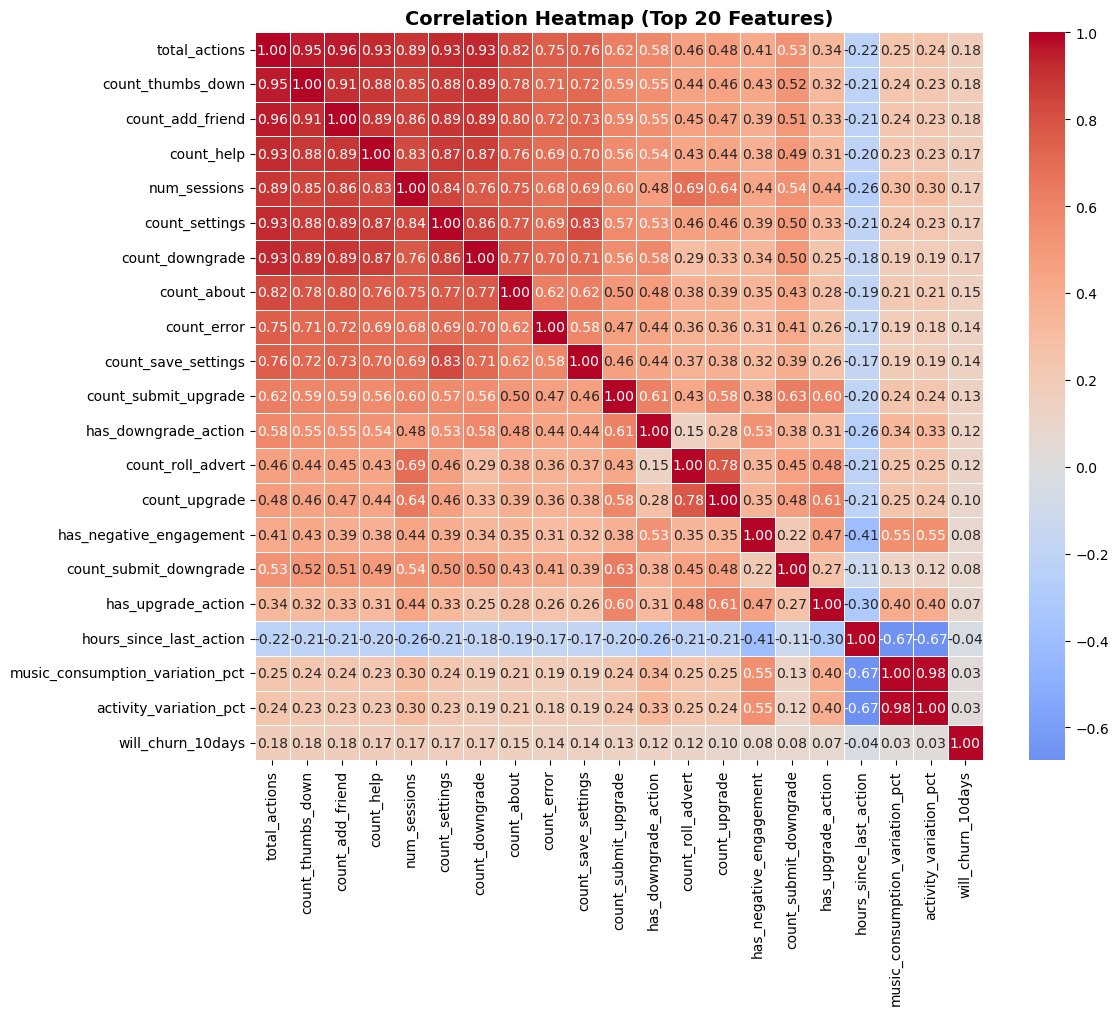

In [ ]:
plot_correlation_heatmap(df_consistant)

In [ ]:
def remove_correlated_features(df, threshold=0.9):
    """
    Remove highly correlated features.
    """
    # Correlation matrix
    feature_cols = [col for col in df.columns 
                   if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]
    
    corr_matrix = df[feature_cols].corr().abs()
    
    # Find pairs with correlation > threshold
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # Keep the one more correlated with target
                corr_target_i = abs(df[corr_matrix.columns[i]].corr(df['will_churn_10days']))
                corr_target_j = abs(df[corr_matrix.columns[j]].corr(df['will_churn_10days']))
                
                if corr_target_i < corr_target_j:
                    to_drop.add(corr_matrix.columns[i])
                else:
                    to_drop.add(corr_matrix.columns[j])
    
    print(f"Removing {len(to_drop)} correlated features:")
    print(list(to_drop))
    
    df_cleaned = df.drop(columns=list(to_drop))
    return df_cleaned



In [ ]:
df_cleaned = remove_correlated_features(df_buffered, threshold=0.85)

Removing 7 correlated features:
['num_sessions', 'count_downgrade', 'count_add_friend', 'count_settings', 'count_help', 'activity_variation_pct', 'count_thumbs_down']


In [ ]:
df_cleaned

,userId,session_start,registration,will_churn_10days,hours_since_last_action,days_since_registration,count_about,count_error,count_save_settings,count_upgrade,...,count_submit_upgrade,count_roll_advert,total_actions,skip_rate,like_ratio,music_consumption_variation_pct,previous_week_actions,has_downgrade_action,has_upgrade_action,has_negative_engagement
sessionId,,,,,,,,,,,,,,,,,,,,,
698,1000804,2018-10-02 15:05:45,2018-09-01 08:10:27,0,750.921667,31.288403,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
15593,1000804,2018-10-22 14:12:24,2018-09-01 08:10:27,1,70.368889,51.251354,0,0,0,1,...,0,10,203,0.212500,0.062500,100,0,0,1,1
649,1001177,2018-10-02 11:59:06,2018-09-20 04:34:26,0,295.411111,12.308796,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
872,1001256,2018-10-12 15:47:47,2018-06-11 01:16:56,0,2966.514167,123.604757,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
485,1002584,2018-10-01 14:27:06,2018-06-11 20:43:43,1,2681.723056,111.738461,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130445,1996686,2018-11-07 06:38:11,2018-09-10 21:57:51,0,260.804167,57.361343,0,0,0,0,...,0,1,19,0.214286,0.000000,100,0,0,0,0
166797,1996686,2018-11-07 18:32:54,2018-09-10 21:57:51,0,11.187778,57.857674,0,0,0,0,...,0,1,34,0.240000,0.080000,100,0,0,0,0
141766,1997612,2018-11-07 09:05:35,2018-08-31 03:10:10,0,177.697500,68.246817,0,0,0,0,...,0,0,62,0.115385,0.038462,100,0,1,0,1


## Model selection

### First training with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

def random_forest_training(df_features):
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    print(f"Features: {len(feature_cols)}")
    print(f"Dataset size: {len(X)}")
    print(f"Label distribution:\n{y.value_counts(normalize=True)}")

    # Split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train Random Forest with better parameters for imbalanced data
    model = RandomForestClassifier(
        n_estimators=100,           # Number of trees
        max_depth=15,               # Limit depth to avoid overfitting
        min_samples_split=10,       # Minimum samples to split a node
        min_samples_leaf=5,         # Minimum samples in a leaf
        class_weight='balanced',    # CRITICAL: Handle class imbalance
        random_state=42,
        n_jobs=-1                   # Use all CPU cores
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn

    # Evaluation with appropriate metrics
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    print(f"\nAccuracy: {model.score(X_test, y_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    print("\nTop 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(10).to_string(index=False))
    return model

In [ ]:
random_forest_training(df_consistant)

Features: 24
Dataset size: 119755
Label distribution:
will_churn_10days
0    0.892272
1    0.107728
Name: proportion, dtype: float64

MODEL EVALUATION

Accuracy: 0.8674
F1-Score: 0.4443
ROC-AUC: 0.7911

Confusion Matrix:
[[19504  1867]
 [ 1310  1270]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.91      0.92     21371
       Churn       0.40      0.49      0.44      2580

    accuracy                           0.87     23951
   macro avg       0.67      0.70      0.68     23951
weighted avg       0.88      0.87      0.87     23951


Top 10 Most Important Features:
                feature  importance
days_since_registration    0.105895
hours_since_last_action    0.099243
          total_actions    0.087923
             like_ratio    0.086968
              skip_rate    0.073177
      count_thumbs_down    0.066636
       count_add_friend    0.062170
      count_roll_advert    0.055790
           num_sessions    0.055761
    

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, min_samples_split=10, n_jobs=-1,
                       random_state=42)

We need to deal with classe imbalance

### Second try with XG Boost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

def XGB_training(df_features):

    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    # Split (NO resampling here!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight: ratio of negative to positive class
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    print(f"Class distribution in train:")
    print(y_train.value_counts())
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost with optimal parameters for churn prediction
    model = xgb.XGBClassifier(
        # Handle imbalanced classes
        scale_pos_weight=scale_pos_weight,  # CRITICAL for imbalanced data
        
        # Model complexity
        n_estimators=100,                   # Number of boosting rounds
        max_depth=6,                        # Tree depth (prevent overfitting)
        learning_rate=0.05,                 # Lower = more robust but slower
        
        # Optimization
        objective='binary:logistic',        # Binary classification,                 
        random_state=42,
        n_jobs=-1
    )

    # Train (simplified - no need to pass eval_metric again)
    print("\nTraining XGBoost model...")
    model.fit(
        X_train, y_train,
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    import pandas as pd
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    return model


In [ ]:
model_XGB = XGB_training(df_consistant)

Class distribution in train:
will_churn_10days
0    85483
1    10321
Name: count, dtype: int64

Calculated scale_pos_weight: 8.28

Training XGBoost model...
balanced accuracy: 0.6647052859794426
ROC-AUC: 0.7314

Confusion Matrix:
[[14909  6462]
 [  950  1630]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.70      0.80     21371
       Churn       0.20      0.63      0.31      2580

    accuracy                           0.69     23951
   macro avg       0.57      0.66      0.55     23951
weighted avg       0.86      0.69      0.75     23951


Top 15 Most Important Features:
                feature  importance
      count_thumbs_down    0.155713
          total_actions    0.146918
           num_sessions    0.097752
   count_submit_upgrade    0.064083
hours_since_last_action    0.063311
             like_ratio    0.050536
 count_submit_downgrade    0.050405
        count_downgrade    0.046069
         count_settings    0.03

In [ ]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

def find_optimal_threshold(model, X_test, y_test, thresholds=None, plot=True):
    """
    Trouve le seuil qui maximise la Balanced Accuracy
    
    Returns:
    --------
    best_threshold : float
        Optimal threshold
    best_score : float
        Balanced Accuracy at optimal threshold
    results : dict
        All thresholds and their scores
    """
    # Prédictions probabilistes
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Thresholds à tester
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.01)
    
    # Stocker les résultats
    scores = []
    
    # Tester chaque seuil
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        ba = balanced_accuracy_score(y_test, y_pred_binary)
        scores.append(ba)
    
    # Trouver le meilleur
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_score = scores[best_idx]
    
    # Affichage
    print(f"🎯 Optimal Threshold: {best_threshold:.3f}")
    print(f"📊 Balanced Accuracy: {best_score:.3f}")
    
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, scores, linewidth=2)
        plt.axvline(best_threshold, color='red', linestyle='--', 
                    label=f'Optimal = {best_threshold:.3f}')
        plt.axhline(best_score, color='red', linestyle='--', alpha=0.3)
        plt.xlabel('Threshold', fontsize=12)
        plt.ylabel('Balanced Accuracy', fontsize=12)
        plt.title('Balanced Accuracy vs Classification Threshold', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    
    # Retourner les résultats
    results = {
        'thresholds': thresholds,
        'scores': scores
    }
    
    return best_threshold, best_score, results

🎯 Optimal Threshold: 0.510
📊 Balanced Accuracy: 0.665


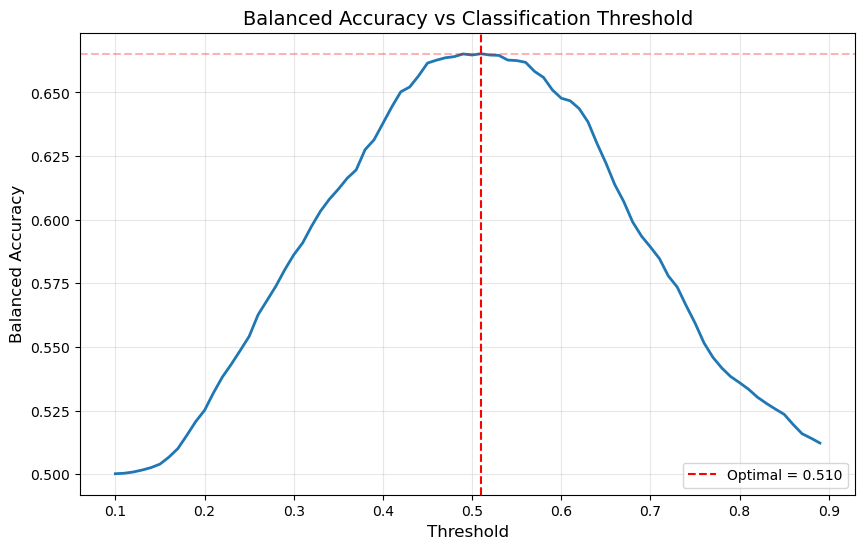

In [ ]:
# 📌 UTILISATION
# Après avoir entraîné ton modèle
best_threshold, best_ba, results = find_optimal_threshold(model_XGB, X_test, y_test)

# Prédictions avec le seuil optimal
y_pred_optimal = (model_XGB.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

### Rebalance the classes with a SMOTE function

In [ ]:
# We apply smote only to train sets
def apply_smote(df_features):
    """
    Apply SMOTE to balance classes.
    """
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                   if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"Before SMOTE: {len(y_train)} samples")
    print(f"After SMOTE:  {len(y_train_balanced)} samples")
    print(f"Class 0: {(y_train_balanced==0).sum()}, Class 1: {(y_train_balanced==1).sum()}")
    
    return X_train_balanced, y_train_balanced, X_test, y_test

In [ ]:
X_train_balanced, y_train_balanced, X_test, y_test = apply_smote(df_consistant)

Before SMOTE: 95804 samples
After SMOTE:  170966 samples
Class 0: 85483, Class 1: 85483


In [ ]:
from sklearn.metrics import balanced_accuracy_score
def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, roc_auc_score
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    return rf, roc_auc

In [ ]:
model_rf_SMOTE, score = train_random_forest(X_train_balanced, y_train_balanced, X_test, y_test)

balanced accuracy: 0.725782602592298
ROC-AUC: 0.8140

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.94      0.89      0.92     21371
       Churn       0.38      0.56      0.45      2580

    accuracy                           0.85     23951
   macro avg       0.66      0.73      0.68     23951
weighted avg       0.88      0.85      0.87     23951



🎯 Optimal Threshold: 0.420
📊 Balanced Accuracy: 0.734


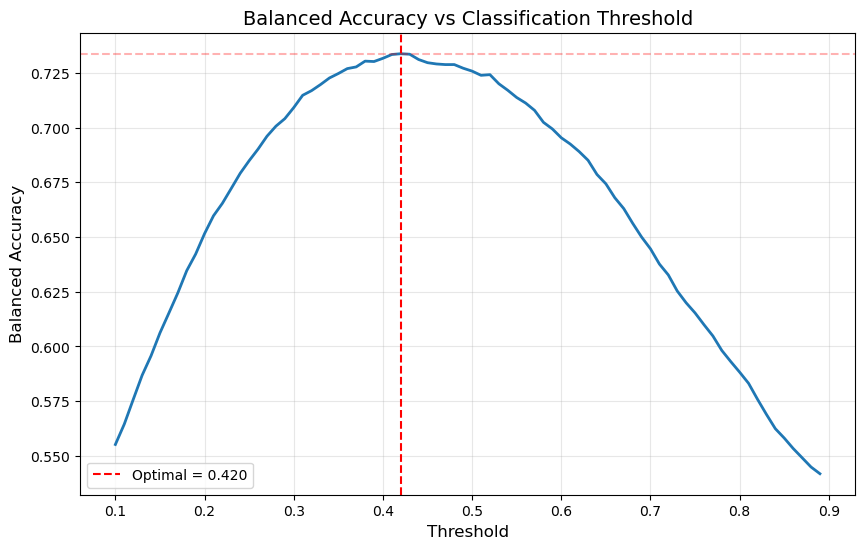

In [ ]:
# Après avoir entraîné ton modèle
best_threshold, best_ba, results = find_optimal_threshold(model_rf_SMOTE, X_test, y_test)

# Prédictions avec le seuil optimal
y_pred_optimal = (model_rf_SMOTE.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

In [ ]:
# Prepare data 
feature_cols = [col for col in df_consistant.columns 
                if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

X = df_consistant[feature_cols].fillna(0)
y = df_consistant['will_churn_10days']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
model, score = train_random_forest(X_train, y_train, X_test, y_test)

balanced accuracy: 0.5979984558513873
ROC-AUC: 0.8201

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      1.00      0.95     21371
       Churn       0.98      0.20      0.33      2580

    accuracy                           0.91     23951
   macro avg       0.95      0.60      0.64     23951
weighted avg       0.92      0.91      0.89     23951



## EDA

## Check if linear regression is suitable

In [ ]:

def plot_logistic_regression_diagnostics(df_features):
    """
    Create diagnostic plots for logistic regression suitability.
    """
    
    # Prepare data
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Scale and split
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    y_proba = lr.predict_proba(X_test)[:, 1]
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Logistic Regression Diagnostic Plots', fontsize=16, fontweight='bold')
    
    # 1. ROC Curve
    ax = axes[0, 0]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    
    # 2. Feature Importance
    ax = axes[0, 1]
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': np.abs(lr.coef_[0])
    }).sort_values('coefficient', ascending=False).head(15)
    
    ax.barh(range(len(feature_importance)), feature_importance['coefficient'], color='steelblue')
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['feature'])
    ax.set_xlabel('Absolute Coefficient')
    ax.set_title('Top 15 Feature Importance')
    ax.invert_yaxis()
    
    # 3. Predicted Probability Distribution
    ax = axes[1, 0]
    ax.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='No Churn', color='green')
    ax.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Churn', color='red')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title('Predicted Probability Distribution by Class')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 4. Top Feature Distributions by Class
    ax = axes[1, 1]
    top_feature = feature_importance.iloc[0]['feature']
    top_feature_idx = feature_cols.index(top_feature)
    
    ax.violinplot([X_scaled[y == 0, top_feature_idx], X_scaled[y == 1, top_feature_idx]], 
                   positions=[0, 1], showmeans=True)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_ylabel('Scaled Value')
    ax.set_title(f'Distribution of Top Feature: {top_feature}')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [ ]:
plot_logistic_regression_diagnostics(X)

KeyError: 'will_churn_10days'